# Clustering

Фильтр на предупреждения.

In [1]:
import warnings
warnings.filterwarnings('ignore')

## Подготовка

Импорт библиотек для работы.

In [2]:
import numpy as np
import pandas as pd
import seaborn as sns
import pywt
import matplotlib.pyplot as plt

from sklearn.preprocessing import StandardScaler
from sklearn.utils import resample 
from sklearn.manifold import TSNE
from sklearn.cluster import KMeans
from scipy.spatial import distance
from scipy.signal import lfilter
from scipy import signal
from typing import List
from datetime import datetime

## Практика 1

### Задание 1

Подготовка в Excel таблицы значений функции sin(x), где аргумент x изменяется от 0 до 10 с шагом 0,05. 

In [3]:
x = np.arange(0, 10, 0.05)
y = np.sin(x)

y_first = pd.DataFrame(y, columns=['Y'])
y_first.describe()

,Y
count,200.000000
mean,0.185229
std,0.666609
min,-0.999923
25%,-0.379695
50%,0.315320
75%,0.809726
max,0.999992


Удаление нескольких значений функции (не аргумента), так чтобы были пропущенные данные.

In [4]:
y_new = y.__deepcopy__(y)
y_new[1::10] = None

y_target = pd.DataFrame(y_new, columns=['Y'])
y_target.describe()

,Y
count,180.000000
mean,0.184359
std,0.667405
min,-0.999923
25%,-0.383538
50%,0.315320
75%,0.809726
max,0.999992


Восстановим значения c помощью *fillna*:

In [5]:
y_fill = y_target.fillna(method='ffill')
y_fill.describe()

,Y
count,200.000000
mean,0.185290
std,0.666565
min,-0.999923
25%,-0.368329
50%,0.315320
75%,0.809726
max,0.999992


Сравним результаты, cредняя ошибка равна ~**0.0323**:

In [6]:
diff = y_first - y_fill
diff = [res for res in diff.values if float(res) > 0.0]
sum(diff)/len(diff)

array([0.03230465])

### Задание 2

Скопируем в файл Anketa.txt и отобразим таблицу и точечную диаграмму для поля Сумма кредита. 

In [7]:
anketa = pd.read_csv("anketa.csv", encoding='windows-1251', sep='\t')
anketa

,Фамилия,Имя,Отчество,КодАнкеты,"Сумма кредита, руб#"
0,Абаджев,Николай,Васильевич,3049,47000
1,Абаев,Александр,Викторович,3061,32000
2,Алексенко,Дмитрий,Дмитриевич,4012,64000
3,Беляев,Юрий,Алефтинович,3053,25000
4,Бобров,Андрей,Владимирович,4076,105000
...,...,...,...,...,...
82,Якуб,Андрей,Сергеевич,4077,17000
83,Бобров,Андрей,Владимирович,4076,105000
84,Широкова,Светлана,Николаевна,4000,54000
85,Полякова,Тамара,Ивановна,3076,36000


In [8]:
anketa.describe()

,КодАнкеты,"Сумма кредита, руб#"
count,87.000000,87.000000
mean,3792.471264,50160.919540
std,427.087482,20141.865207
min,3049.000000,17000.000000
25%,3537.500000,38000.000000
50%,4021.000000,47000.000000
75%,4056.500000,60500.000000
max,4084.000000,140000.000000


Построим распределение:

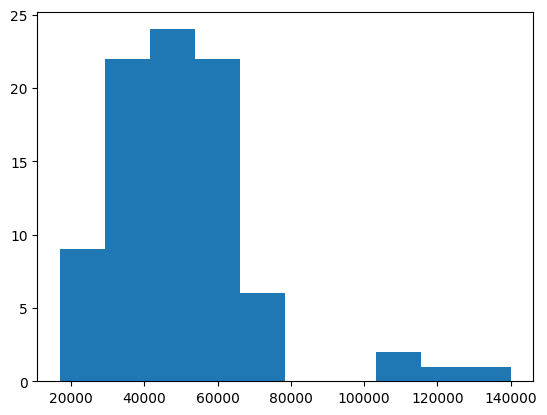

In [9]:
plt.hist(anketa['Сумма кредита, руб#'])
plt.show()

Отобразим выбросы по сумме кредита с помощью графика **ящик с усами**:

<Axes: ylabel='Сумма кредита, руб#'>

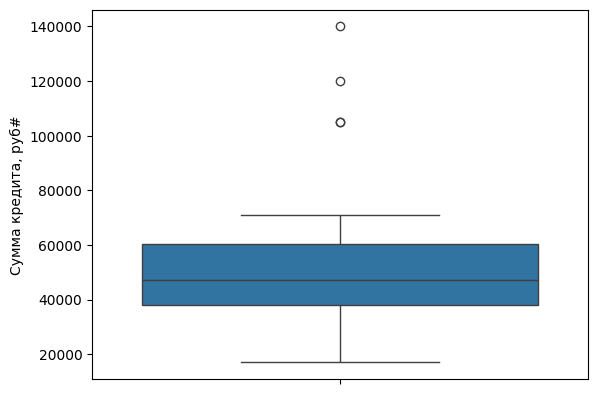

In [10]:
sns.boxplot(anketa['Сумма кредита, руб#'])

Отсечем значения, которые выше 80000:

In [11]:
anketa_80000 = anketa.loc[anketa['Сумма кредита, руб#'] <= 80000]

In [12]:
anketa_80000

,Фамилия,Имя,Отчество,КодАнкеты,"Сумма кредита, руб#"
0,Абаджев,Николай,Васильевич,3049,47000
1,Абаев,Александр,Викторович,3061,32000
2,Алексенко,Дмитрий,Дмитриевич,4012,64000
3,Беляев,Юрий,Алефтинович,3053,25000
5,Бочкарев,Рудольф,Алексеевич,4002,31000
...,...,...,...,...,...
81,Шуклин,Виталий,Георгиевич,3067,36000
82,Якуб,Андрей,Сергеевич,4077,17000
84,Широкова,Светлана,Николаевна,4000,54000
85,Полякова,Тамара,Ивановна,3076,36000


In [13]:
anketa_80000.describe()

,КодАнкеты,"Сумма кредита, руб#"
count,83.000000,83.000000
mean,3779.759036,46915.662651
std,433.256601,13548.652007
min,3049.000000,17000.000000
25%,3076.000000,38000.000000
50%,4020.000000,46000.000000
75%,4054.500000,59000.000000
max,4084.000000,71000.000000


Перестроим распределение:

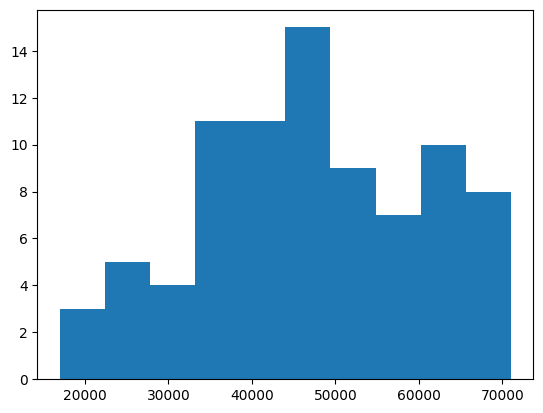

In [14]:
plt.hist(anketa_80000['Сумма кредита, руб#'])
plt.show()

Другой вариант - отсечем по персентилям, где возьмем персентиль **10 <= x <= 90**:

In [15]:
lq, uq = anketa['Сумма кредита, руб#'].quantile([.1, .9])
quantile = anketa.loc[(anketa['Сумма кредита, руб#'] > lq) & (anketa['Сумма кредита, руб#'] < uq)]
quantile

,Фамилия,Имя,Отчество,КодАнкеты,"Сумма кредита, руб#"
0,Абаджев,Николай,Васильевич,3049,47000
1,Абаев,Александр,Викторович,3061,32000
2,Алексенко,Дмитрий,Дмитриевич,4012,64000
5,Бочкарев,Рудольф,Алексеевич,4002,31000
6,Варов,Валентин,Иванович,4028,57000
...,...,...,...,...,...
80,Широкова,Светлана,Николаевна,4000,54000
81,Шуклин,Виталий,Георгиевич,3067,36000
84,Широкова,Светлана,Николаевна,4000,54000
85,Полякова,Тамара,Ивановна,3076,36000


In [16]:
quantile.describe()

,КодАнкеты,"Сумма кредита, руб#"
count,68.000000,68.000000
mean,3750.823529,48117.647059
std,447.222337,10206.128407
min,3049.000000,31000.000000
25%,3073.750000,39750.000000
50%,4013.500000,47000.000000
75%,4054.250000,57250.000000
max,4083.000000,66000.000000


Перестроим распределение для 10 и 90 персентиля:

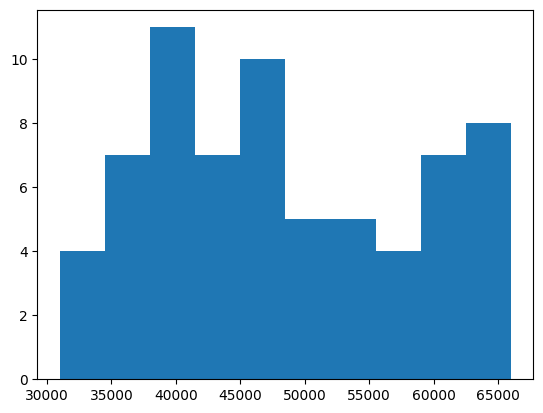

In [17]:
plt.hist(quantile['Сумма кредита, руб#'])
plt.show()

### Задание 3

Откроем файл:

In [18]:
dynamics_website = pd.read_csv("dynamics_website.csv", encoding='windows-1251', sep='\t')
dynamics_website.head()

,Дата,Посещения
0,01.01.2009,"163,654"
1,01.12.2008,"180,472"
2,01.11.2008,"184,68"
3,01.10.2008,"190,564"
4,01.09.2008,"164,578"


Преобразуем данные к нормальному виду:

In [19]:
dynamics_website['Посещения'] = [int(val.replace(',', '')) for val in dynamics_website['Посещения'].values]
dynamics_website['Дата'] = [datetime.strptime(val, '%d.%m.%Y').date() for val in dynamics_website['Дата'].values]

Построим график для просмотра изменений трафика:

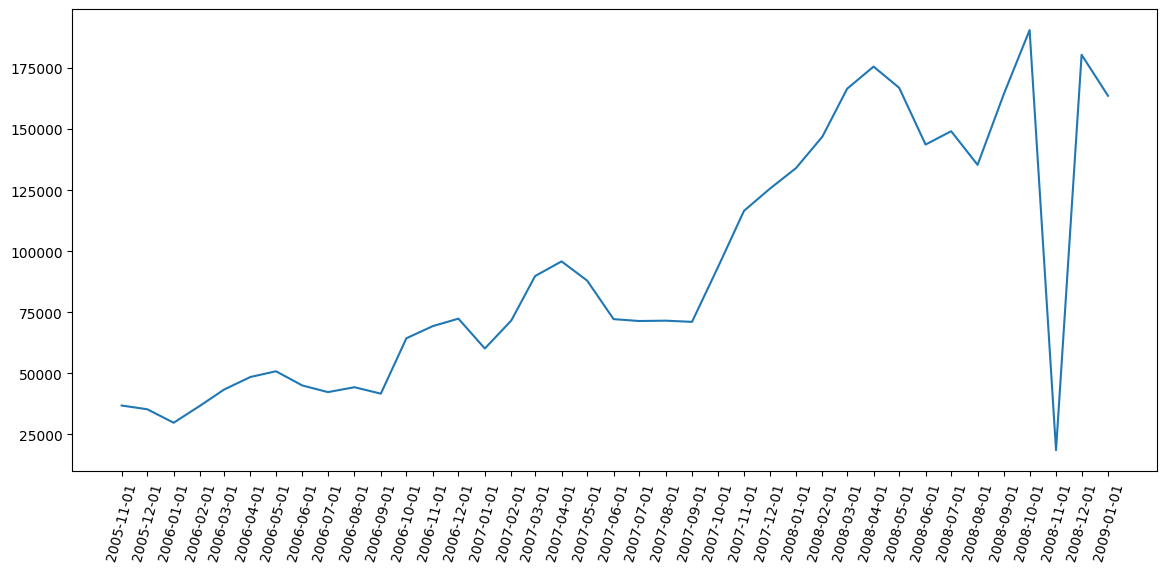

In [20]:
plt.figure(figsize = (14,6))
plt.plot(dynamics_website['Дата'], dynamics_website['Посещения'])
plt.xticks(dynamics_website['Дата'], rotation=75)
plt.show()


Используем фильтр Савицкого-Голея для сглаживания с разными параметрами:

In [21]:
yhat_ = [signal.savgol_filter(dynamics_website['Посещения'], x, 3) for x in [4, 5, 7, 10, 15]]

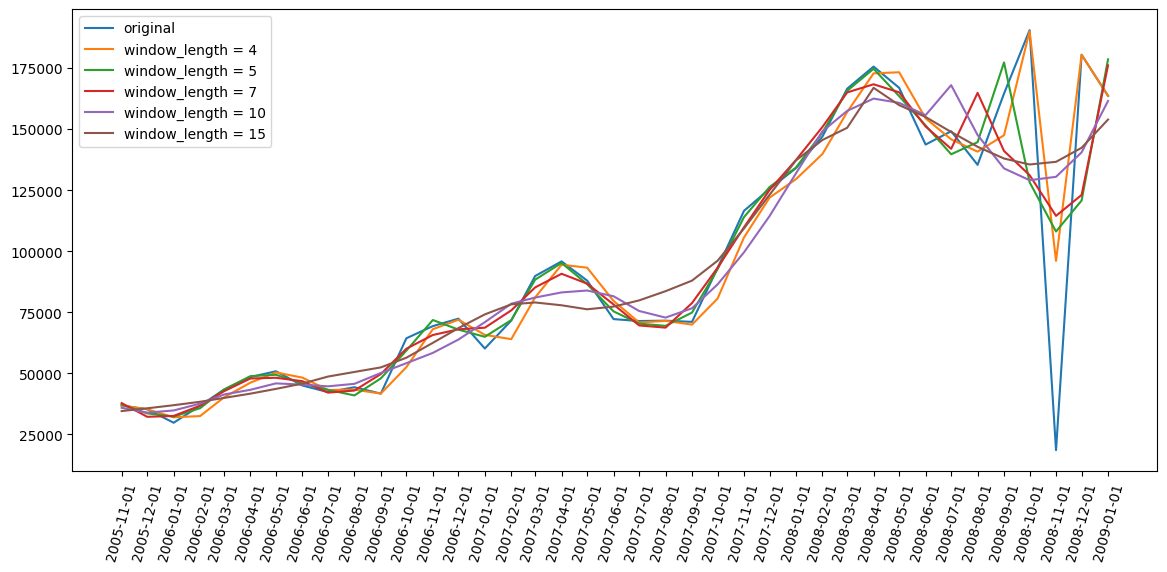

In [22]:
plt.figure(figsize = (14,6))
plt.plot(dynamics_website['Дата'], dynamics_website['Посещения'], label='original')
plt.plot(dynamics_website['Дата'], yhat_[0], label='window_length = 4')
plt.plot(dynamics_website['Дата'], yhat_[1], label='window_length = 5')
plt.plot(dynamics_website['Дата'], yhat_[2], label='window_length = 7')
plt.plot(dynamics_website['Дата'], yhat_[3], label='window_length = 10')
plt.plot(dynamics_website['Дата'], yhat_[4], label='window_length = 15')
plt.xticks(dynamics_website['Дата'], rotation=75)
plt.legend(loc='best')
plt.show()

Также сравним с методом скользящего среднего:

In [23]:
weights = [[0.1, 0.2, 0.3, 0.4], [0.2, 0.3, 0.5], [0.2, 0.4, 0.4], [0.15, 0.15, 0.7], [0.2, 0.35, 0.3, 0.15]]
weights_y = [np.convolve(dynamics_website['Посещения'], np.array(w)[::-1],'same') for w in weights]

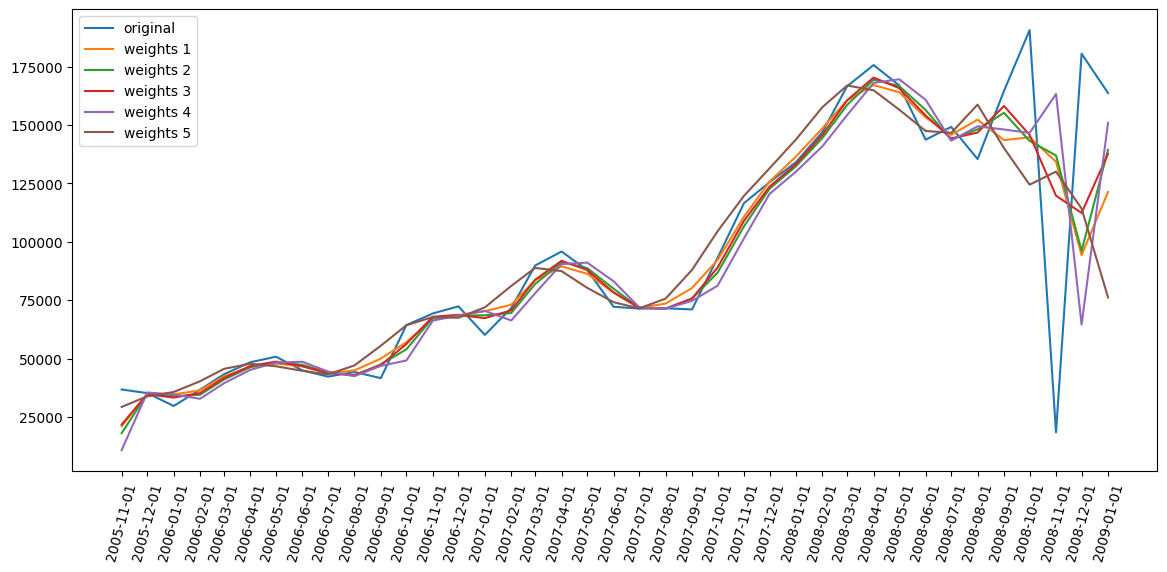

In [24]:
plt.figure(figsize = (14,6))
plt.plot(dynamics_website['Дата'], dynamics_website['Посещения'], label='original')
plt.plot(dynamics_website['Дата'], weights_y[0], label='weights 1')
plt.plot(dynamics_website['Дата'], weights_y[1], label='weights 2')
plt.plot(dynamics_website['Дата'], weights_y[2], label='weights 3')
plt.plot(dynamics_website['Дата'], weights_y[3], label='weights 4')
plt.plot(dynamics_website['Дата'], weights_y[4], label='weights 5')
plt.xticks(dynamics_website['Дата'], rotation=75)
plt.legend(loc='best')
plt.show()

Пропишем вычитание шума с разной степенью вычитания:

In [25]:
noises = [2, 3, 5, 7, 10]
noises_y = [lfilter([1.0 / n] * n, 1, dynamics_website['Посещения']) for n in noises]

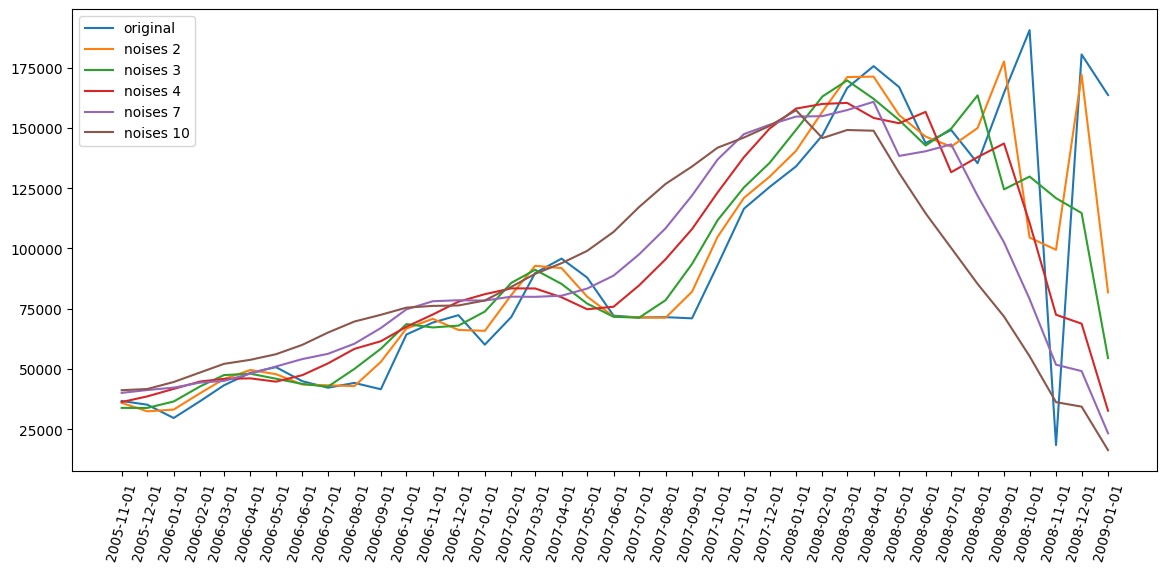

In [26]:
plt.figure(figsize = (14,6))
plt.plot(dynamics_website['Дата'], dynamics_website['Посещения'], label='original')
plt.plot(dynamics_website['Дата'], noises_y[0], label='noises 2')
plt.plot(dynamics_website['Дата'], noises_y[1], label='noises 3')
plt.plot(dynamics_website['Дата'], noises_y[2], label='noises 4')
plt.plot(dynamics_website['Дата'], noises_y[3], label='noises 7')
plt.plot(dynamics_website['Дата'], noises_y[4], label='noises 10')
plt.xticks(dynamics_website['Дата'], rotation=75)
plt.legend(loc='best')
plt.show()

Используем вейвлет-преобразование с глубиной 3 и порядком 6:

In [27]:
coeffs = pywt.wavedec(dynamics_website['Посещения'], 'db3', level=6)

threshold = 1
coeffs_thresholded = [pywt.threshold(c, threshold, mode='soft') for c in coeffs]

denoised_signal = pywt.waverec(coeffs_thresholded, 'db3')

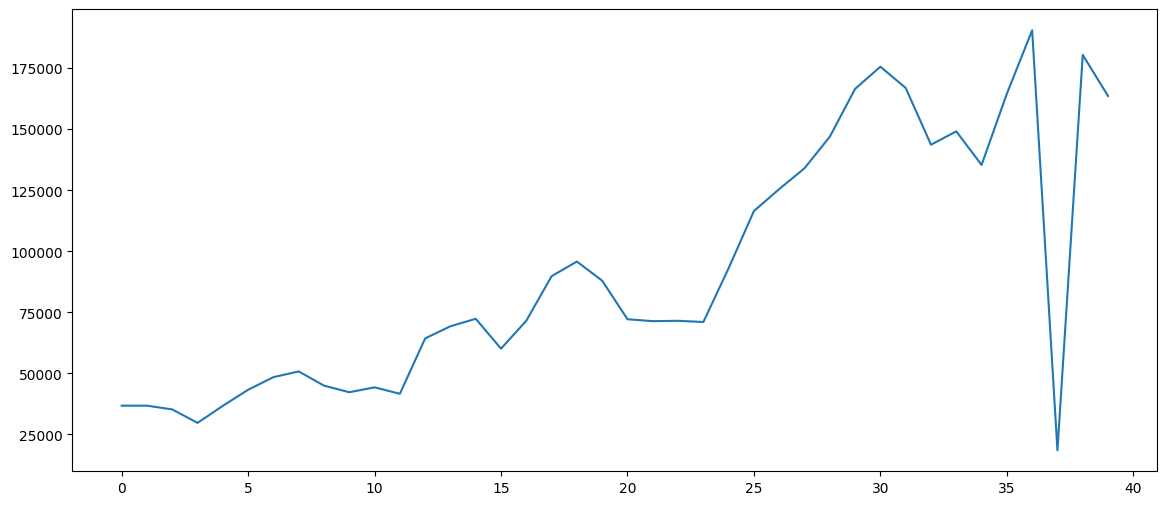

In [28]:
plt.figure(figsize = (14,6))
plt.plot(denoised_signal[::-1])
plt.show()

**Фильтр Савицкого-Голея** показал самое качественное сглаживания, сохранив тенденцию к росту и перепадам, и сгладив локальный минимум от 2008-11-01. Неоптимальный подбор коэффициентов для вейвлет-преобразования не показал значимого результата.

### Задание для самостоятельной работы

Прочитаем файл:

In [29]:
trade = pd.read_csv("trade.csv", encoding='windows-1251', sep='\t')
trade.head()

,Дата (Год + Месяц),Количество
0,2000-M01,462523.4190
1,2000-M02,633208.1960
2,2000-M03,660159.2990
3,2000-M04,617455.3417
4,2000-M05,597354.4794


In [30]:
trade.describe()

,Количество
count,5.000000e+01
mean,1.651531e+06
std,5.549682e+05
min,4.625234e+05
25%,1.370451e+06
50%,1.701352e+06
75%,2.080112e+06
max,2.662781e+06


Построим график исходных данных:

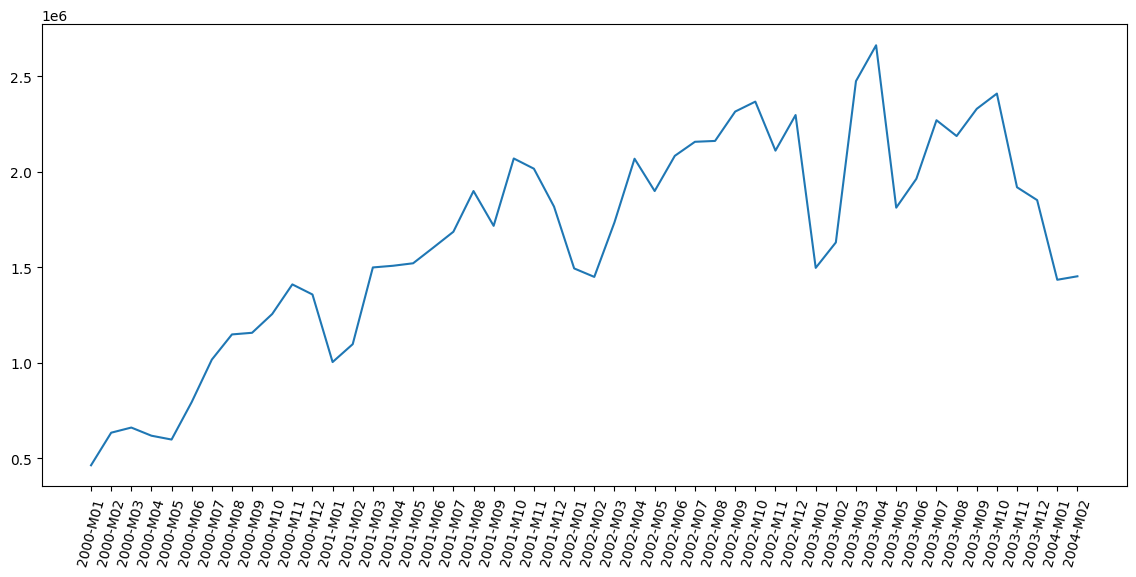

In [31]:
plt.figure(figsize = (14,6))
plt.plot(trade['Дата (Год + Месяц)'], trade['Количество'])
plt.xticks(trade['Дата (Год + Месяц)'], rotation=75)
plt.show()

Построим график ящик с усами:

<Axes: ylabel='Количество'>

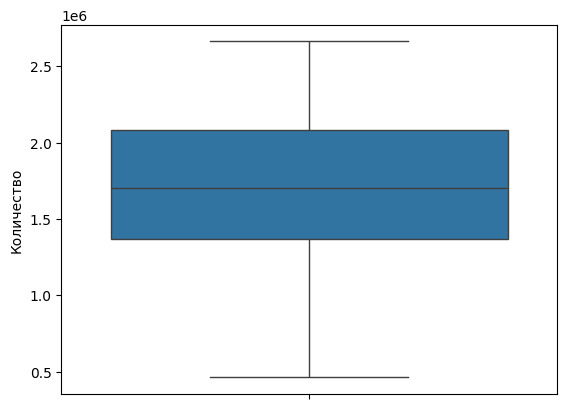

In [32]:
sns.boxplot(trade['Количество'])

Оставим данные между 5 персентилем и 95 персенитилем:

In [33]:
lq, uq = trade['Количество'].quantile([.05, .95])
quantile = trade.loc[(trade['Количество'] > lq) & (trade['Количество'] < uq)]

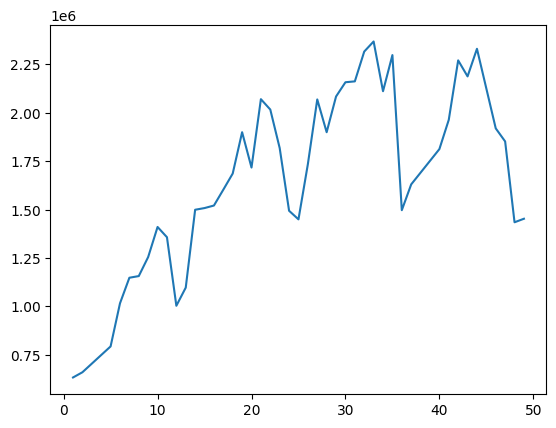

In [34]:
plt.plot(quantile['Количество'])

<Axes: ylabel='Количество'>

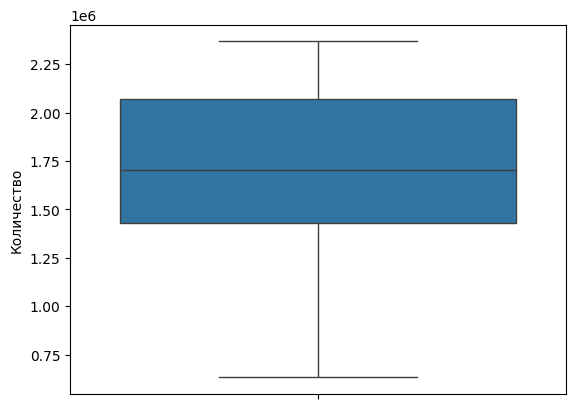

In [35]:
sns.boxplot(quantile['Количество'])

In [36]:
trade = quantile.__deepcopy__()

Аппроксимируем с разной степенью полинома и выберем самый оптимальный:

In [37]:
datas = range(len(trade['Количество']))
coeffs_poly = [np.polyfit(datas, trade['Количество'], degree) for degree in [3, 5, 7, 10, 15, 20, 25]]
poly_n = [poly(datas) for poly in[np.poly1d(cf) for cf in coeffs_poly]]
mse_s = [np.round(np.mean(poly)/len(datas), 4) for poly in poly_n]


C:\Users\DanOn\AppData\Local\Temp\ipykernel_12788\1018857919.py:2: RankWarning: Polyfit may be poorly conditioned
  coeffs_poly = [np.polyfit(datas, trade['Количество'], degree) for degree in [3, 5, 7, 10, 15, 20, 25]]
C:\Users\DanOn\AppData\Local\Temp\ipykernel_12788\1018857919.py:2: RankWarning: Polyfit may be poorly conditioned
  coeffs_poly = [np.polyfit(datas, trade['Количество'], degree) for degree in [3, 5, 7, 10, 15, 20, 25]]


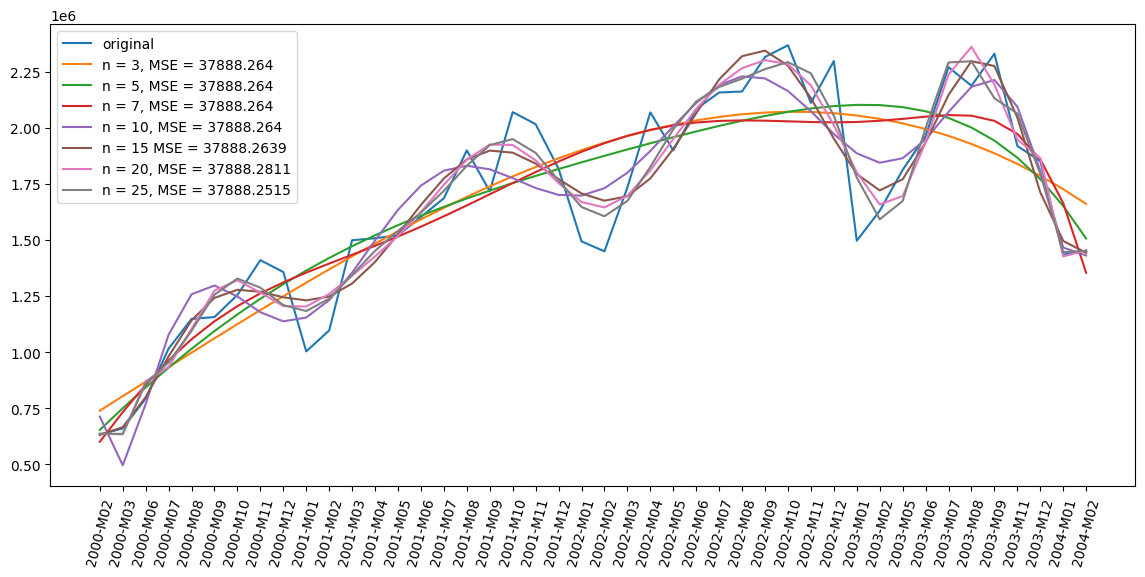

In [38]:
plt.figure(figsize = (14,6))
plt.plot(trade['Дата (Год + Месяц)'], trade['Количество'], label='original')
plt.plot(trade['Дата (Год + Месяц)'], poly_n[0], label=f'n = 3, MSE = {mse_s[0]}')
plt.plot(trade['Дата (Год + Месяц)'], poly_n[1], label=f'n = 5, MSE = {mse_s[1]}')
plt.plot(trade['Дата (Год + Месяц)'], poly_n[2], label=f'n = 7, MSE = {mse_s[2]}')
plt.plot(trade['Дата (Год + Месяц)'], poly_n[3], label=f'n = 10, MSE = {mse_s[3]}')
plt.plot(trade['Дата (Год + Месяц)'], poly_n[4], label=f'n = 15 MSE = {mse_s[4]}')
plt.plot(trade['Дата (Год + Месяц)'], poly_n[5], label=f'n = 20, MSE = {mse_s[5]}')
plt.plot(trade['Дата (Год + Месяц)'], poly_n[6], label=f'n = 25, MSE = {mse_s[6]}')
plt.xticks(trade['Дата (Год + Месяц)'], rotation=75)
plt.legend(loc='best')
plt.show()

Оставими степень полинома равную 25:

In [39]:
trade['Количество'] = poly_n[6]

Построим графики сглаживания для подбора оптимальных параметров:

In [40]:
yhat_ = [signal.savgol_filter(trade['Количество'], x, 3) for x in [4, 5, 7, 10, 15]]
mse_s = [np.round(np.mean(yhat)/len(datas), 4) for yhat in yhat_]

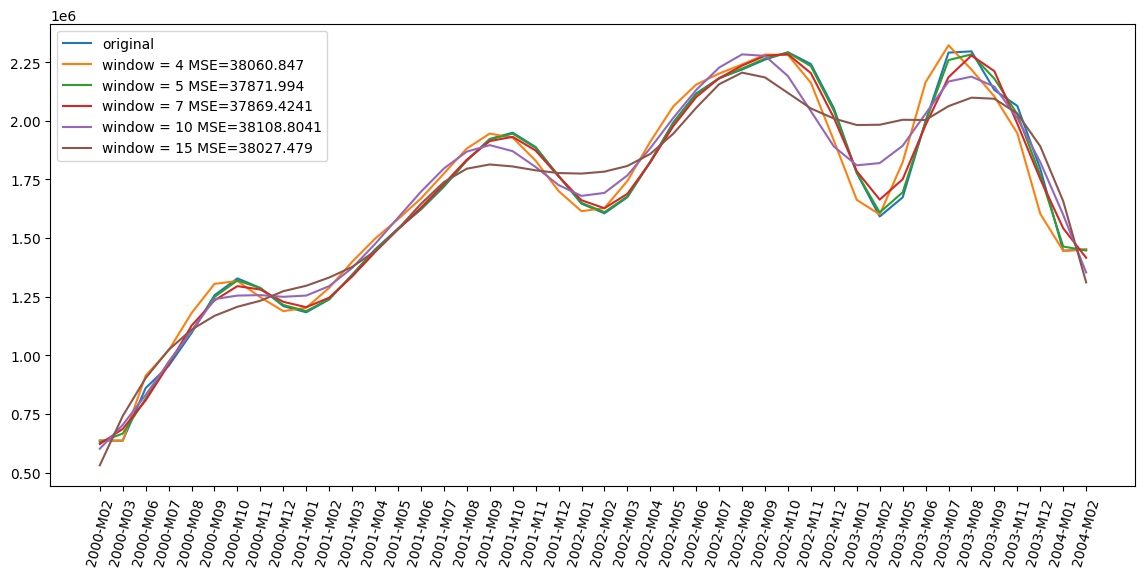

In [41]:
plt.figure(figsize = (14,6))
plt.plot(trade['Дата (Год + Месяц)'], trade['Количество'], label='original')
plt.plot(trade['Дата (Год + Месяц)'], yhat_[0], label=f'window = 4 MSE={mse_s[0]}')
plt.plot(trade['Дата (Год + Месяц)'], yhat_[1], label=f'window = 5 MSE={mse_s[1]}')
plt.plot(trade['Дата (Год + Месяц)'], yhat_[2], label=f'window = 7 MSE={mse_s[2]}')
plt.plot(trade['Дата (Год + Месяц)'], yhat_[3], label=f'window = 10 MSE={mse_s[3]}')
plt.plot(trade['Дата (Год + Месяц)'], yhat_[4], label=f'window = 15 MSE={mse_s[4]}')
plt.xticks(trade['Дата (Год + Месяц)'], rotation=75)
plt.legend(loc='best')
plt.show()

Сравним с графиком, после отсечения выбросов:

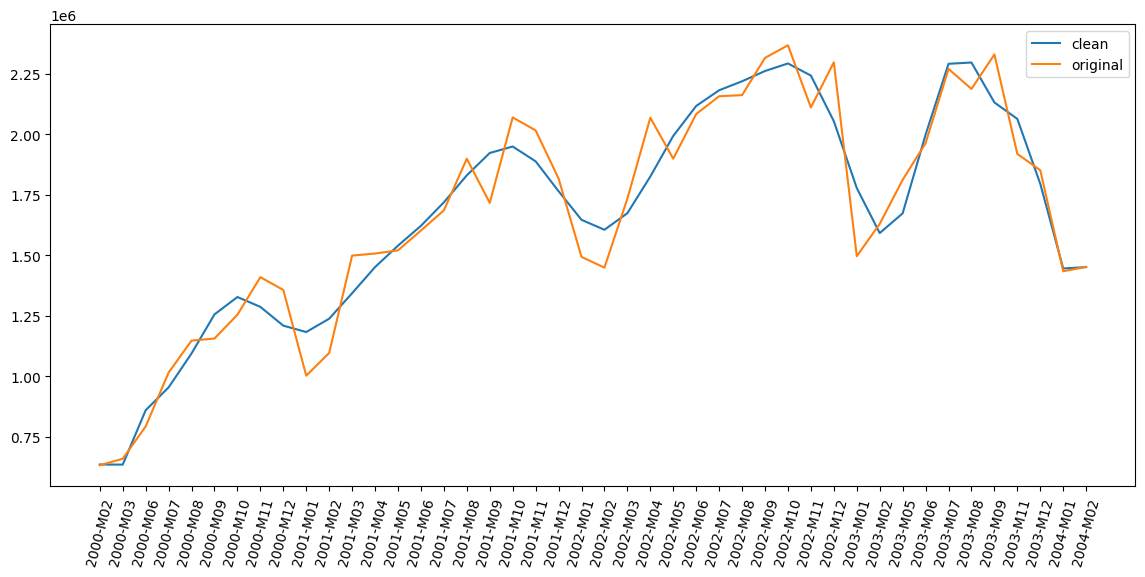

In [42]:
plt.figure(figsize = (14,6))
plt.plot(trade['Дата (Год + Месяц)'], trade['Количество'], label='clean')
plt.plot(trade['Дата (Год + Месяц)'], quantile['Количество'], label='original')
plt.xticks(trade['Дата (Год + Месяц)'], rotation=75)
plt.legend(loc='best')
plt.show()

Вопросы для Самоконтроля:
1. Каково назначение предварительной обработки данных? 
2. Каково назначение обработки дубликатов и противоречий? 
3. В чем отличия предварительной обработки и очистки данных? Какие разделы обычно включает очистка данных?
4. Для чего предназначены парциальная обработка? 
5. Для чего необходимо восстанавливать пропущенные данные?
6. Какие данные считаются зашумленными? Какие варианты сглаживания и вычитания шума существуют?
7. Что такое аномалии и как они могут повлиять на результат анализа данных? Каким образом можно отредактировать аномальные значения?

1. Назначение предварительной обработки данных заключается в подготовке данных к аналитическим или машинному обучению. Это включает в себя очистку данных, нормализацию, трансформацию переменных, обработку пропущенных значений и удаление шума, чтобы данные были корректными, полными и пригодными для анализа.

2. Обработка дубликатов и противоречий необходима для устранения повторяющихся записей, которые могут вводить искажения в аналитические выводы и статистические расчеты. Противоречивые данные — это конфликтующие или несоответствующие записи, которые могут возникать из-за ошибок ввода данных или слияния данных из различных источников. Очистка от противоречий помогает обеспечить консистентность и точность данных.

3. Различия между предварительной обработкой и очисткой данных: предварительная обработка включает в себя широкий диапазон задач, от фильтрации шума и аномалий до сглаживания данных. Очистка данных обычно сосредоточена на устранении ошибок, дубликатов и противоречий. Разделы, которые обычно включает очистка данных, это удаление дубликатов, исправление орфографических ошибок, стандартизация форматов, и исправление некорректных данных.

4. Парциальная обработка предназначена для обработки только тех частей данных, которые требуют вмешательства. Это может быть полезно при больших объемах данных или когда изменения в данных происходят лишь в ограниченных участках. Позволяет экономить ресурсы и время при обработке данных.

5. Восстановление пропущенных данных необходимо для улучшения точности аналитических моделей и предотвращения искажения результатов из-за отсутствия данных. Методы восстановления включают импутацию средними значениями, медианой, модой или использование более сложных методов как множественное внесение, регрессионные модели или использование алгоритмов машинного обучения.

6. Зашумлённые данные – это данные, содержащие ошибочные, иррелевантные или ненужные информации, которые могут вводить смущение в результаты анализа. Методы борьбы с шумом включают сглаживание данных (например, скользящие средние, медианные фильтры), а также более сложные методы, как вейвлет-трансформация для отделения шума от полезного сигнала.

7. Аномалии (выбросы) – это значительно отклоняющиеся или неожиданные значения в данных, которые могут указывать на ошибку или редкое событие. Аномалии могут ввести смещение в аналитические выводы и модели. Для обработки аномалий используются техники, включая усечение данных (удаление выбросов), преобразования данных (например логарифмирование) или статистические методы для обнаружения и обработки аномальных значений, например, Z-счета или IQR (межквартильный размах).

## Практика 2. КЛАСТЕРИЗАЦИЯ ДАННЫХ

### Кластеризация

Требуется распределить регионы на кластеры по демографическим данным.

In [43]:
population = pd.read_csv("population.csv", encoding='windows-1251', sep='\t')
population.head()

,Регион,Численность населения (тыс. чел.),Удельный вес городского населения %,Изменение численности населения,Число родившихся на 1000 населения.,Число умерших на 1000 .,Среднегодовая численность населения занятых в экономике (тыс. чел.),Среднедушевые денежные доходы (руб./мес.)
0,Республика Карелия,766,"74,1","-0,8","7,9","15,1","331,5","1673,4"
1,Республика Коми,1135,"74,2","-1,3","8,5","10,7","495,3","1654,4"
2,Архангельская область,1460,"74,4","-1,3","8,1","15,1","587,8",2058
3,Ненецкий АО,46,"59,2","-0,6","11,2","9,4","20,7","1268,8"
4,Вологодская область,1324,"68,4","-0,7","7,9","15,8","598,4","1692,1"


Отобразим описание:

In [44]:
population.describe()

,Численность населения (тыс. чел.)
count,89.000000
mean,1666.280899
std,1506.263416
min,18.000000
25%,729.000000
50%,1269.000000
75%,2224.000000
max,8631.000000


Изучим характер данных:

In [45]:
population.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 89 entries, 0 to 88
Data columns (total 8 columns):
 #   Column                                                                Non-Null Count  Dtype 
---  ------                                                                --------------  ----- 
 0   Регион                                                                89 non-null     object
 1   Численность населения (тыс. чел.)                                     89 non-null     int64 
 2   Удельный вес городского населения %                                   89 non-null     object
 3   Изменение численности населения                                       89 non-null     object
 4   Число родившихся на 1000 населения.                                   89 non-null     object
 5   Число умерших на 1000 .                                               89 non-null     object
 6   Среднегодовая численность населения занятых в экономике  (тыс. чел.)  89 non-null     object
 7   Среднедушев

Привем все данные кроме региона к численному виду:

In [46]:
cols = population.columns.delete([0, 1])
for col in cols:
    population[col] = [float(str(val).replace(',', '')) for val in population[col]]

In [47]:
population.describe()

,Численность населения (тыс. чел.),Удельный вес городского населения %,Изменение численности населения,Число родившихся на 1000 населения.,Число умерших на 1000 .,Среднегодовая численность населения занятых в экономике (тыс. чел.),Среднедушевые денежные доходы (руб./мес.)
count,89.000000,89.000000,89.000000,89.000000,89.000000,89.000000,89.000000
mean,1666.280899,588.471910,-3.404494,78.415730,133.617978,6613.123596,11401.370787
std,1506.263416,237.073305,64.823137,36.164337,42.955184,7505.399106,8713.528594
min,18.000000,0.000000,-269.000000,0.000000,0.000000,0.000000,0.000000
25%,729.000000,536.000000,-9.000000,72.000000,122.000000,1750.000000,7673.000000
50%,1269.000000,659.000000,-6.000000,79.000000,138.000000,4716.000000,10473.000000
75%,2224.000000,744.000000,-3.000000,93.000000,158.000000,7926.000000,14217.000000
max,8631.000000,919.000000,537.000000,179.000000,214.000000,53997.000000,68591.000000


Построим график ящик с усами:

In [48]:
dirty_col = ['Удельный вес городского населения %', 'Изменение численности населения',
             'Среднегодовая численность населения занятых в экономике  (тыс. чел.)',
             'Среднедушевые денежные доходы (руб./мес.)']

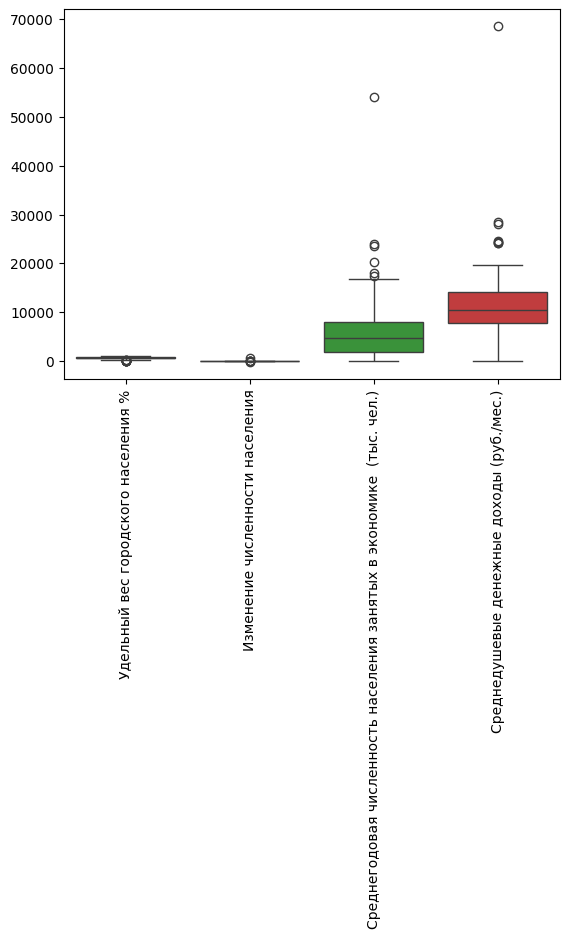

In [49]:
sns.boxplot(population[dirty_col])
plt.xticks(rotation=90)
plt.show()

Почистим выбросы, выбрав медианные значения и установим степень разброса не больше, чем в 10 раз от медианного:

In [50]:
q_population = population.__deepcopy__()

In [51]:
meds = [q_population[col].median() for col in dirty_col]

In [52]:
for col, med in zip(dirty_col, meds):
    q_population = q_population.loc[(abs(q_population[col]) > abs(med*0.1)) & (abs(q_population[col]) < abs(med*10))]

Почистим от шумов:

In [53]:
for col in dirty_col:
    q_population[col] = signal.savgol_filter(q_population[col], 5, 3)

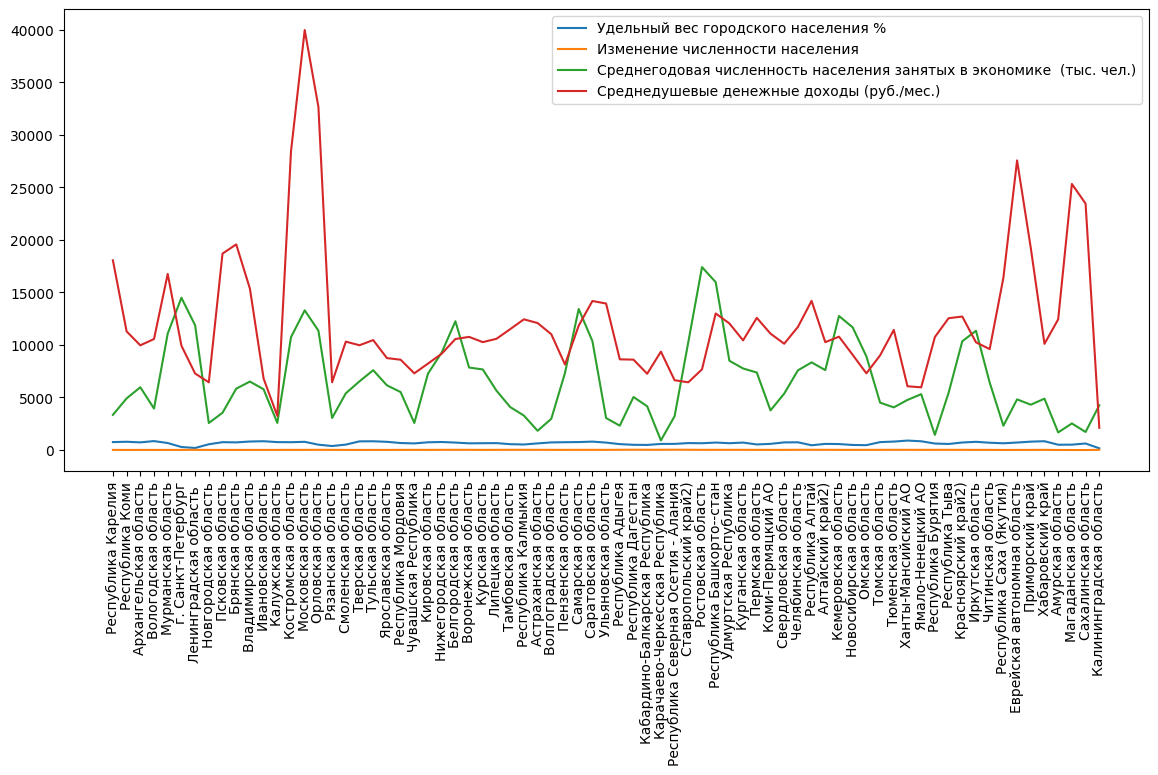

In [54]:
plt.figure(figsize = (14,6))
plt.plot(q_population['Регион'], q_population[dirty_col[0]], label=dirty_col[0])
plt.plot(q_population['Регион'], q_population[dirty_col[1]], label=dirty_col[1])
plt.plot(q_population['Регион'], q_population[dirty_col[2]], label=dirty_col[2])
plt.plot(q_population['Регион'], q_population[dirty_col[3]], label=dirty_col[3])
plt.xticks(q_population['Регион'], rotation=90)
plt.legend(loc='best')
plt.show()

In [55]:
q_population.describe()

,Численность населения (тыс. чел.),Удельный вес городского населения %,Изменение численности населения,Число родившихся на 1000 населения.,Число умерших на 1000 .,Среднегодовая численность населения занятых в экономике (тыс. чел.),Среднедушевые денежные доходы (руб./мес.)
count,73.000000,73.000000,73.000000,73.000000,73.000000,73.000000,73.000000
mean,1717.561644,631.988845,-5.943053,76.342466,141.150685,6562.870450,12097.610763
std,1238.012307,146.800432,5.211004,33.580012,38.665112,3766.830704,6411.979853
min,152.000000,143.357143,-21.457143,7.000000,14.000000,895.914286,2095.828571
25%,949.000000,546.942857,-8.828571,71.000000,126.000000,3755.028571,8619.171429
50%,1357.000000,646.142857,-5.485714,79.000000,144.000000,5631.371429,10555.685714
75%,2459.000000,733.171429,-3.171429,91.000000,165.000000,8484.228571,12572.085714
max,6511.000000,879.342857,6.714286,179.000000,214.000000,17404.514286,39993.114286


Обучим модель kmeans для нахождения 4 кластеров:

In [56]:
kmeans4 = KMeans(n_clusters=4)

In [57]:
kmeans4.fit(q_population[dirty_col])

KMeans(n_clusters=4)

In [58]:
q_population['Кластер_4'] = kmeans4.predict(q_population[dirty_col]) 

Посмотрим на попавшие в выборку регионы:

In [59]:
q_population.loc[q_population['Кластер_4'] == 0].head(3)

,Регион,Численность населения (тыс. чел.),Удельный вес городского населения %,Изменение численности населения,Число родившихся на 1000 населения.,Число умерших на 1000 .,Среднегодовая численность населения занятых в экономике (тыс. чел.),Среднедушевые денежные доходы (руб./мес.),Кластер_4
5,Мурманская область,983,645.742857,-11.600000,76.0,101.0,11074.000000,16756.542857,0
6,г. Санкт-Петербург,4694,267.057143,-9.228571,62.0,154.0,14487.142857,9922.171429,0
7,Ленинградская область,1674,172.971429,-4.857143,65.0,178.0,11866.485714,7267.085714,0


In [60]:
q_population.loc[q_population['Кластер_4'] == 1].head(3)

,Регион,Численность населения (тыс. чел.),Удельный вес городского населения %,Изменение численности населения,Число родившихся на 1000 населения.,Число умерших на 1000 .,Среднегодовая численность населения занятых в экономике (тыс. чел.),Среднедушевые денежные доходы (руб./мес.),Кластер_4
14,Костромская область,786,724.314286,-6.885714,77.0,178.0,10729.000000,28440.314286,1
16,Московская область,6511,760.114286,-6.457143,68.0,167.0,13287.657143,39993.114286,1
17,Орловская область,899,486.742857,-3.171429,73.0,165.0,11350.171429,32673.828571,1


In [61]:
q_population.loc[q_population['Кластер_4'] == 2].head(3)

,Регион,Численность населения (тыс. чел.),Удельный вес городского населения %,Изменение численности населения,Число родившихся на 1000 населения.,Число умерших на 1000 .,Среднегодовая численность населения занятых в экономике (тыс. чел.),Среднедушевые денежные доходы (руб./мес.),Кластер_4
8,Новгородская область,729,526.485714,-8.828571,72.0,191.0,2551.971429,6432.542857,2
12,Ивановская область,1222,817.028571,-9.714286,66.0,203.0,5763.885714,6786.342857,2
13,Калужская область,1081,733.171429,-9.200000,7.0,173.0,2562.314286,3228.085714,2


In [62]:
q_population.loc[q_population['Кластер_4'] == 3].head(3)

,Регион,Численность населения (тыс. чел.),Удельный вес городского населения %,Изменение численности населения,Число родившихся на 1000 населения.,Число умерших на 1000 .,Среднегодовая численность населения занятых в экономике (тыс. чел.),Среднедушевые денежные доходы (руб./мес.),Кластер_4
0,Республика Карелия,766,735.0,-7.671429,79.0,151.0,3328.428571,18050.185714,3
1,Республика Коми,1135,766.0,-14.314286,85.0,107.0,4899.285714,11279.257143,3
2,Архангельская область,1460,708.0,-11.028571,81.0,151.0,5958.571429,9955.114286,3


Обучим модель kmeans для нахождения 5 кластеров:

In [63]:
kmeans5 = KMeans(n_clusters=5)

In [64]:
kmeans5.fit(q_population[dirty_col])

KMeans(n_clusters=5)

In [65]:
q_population['Кластер_5'] = kmeans5.predict(q_population[dirty_col]) 

Посмотрим на попавшие в выборку регионы:

In [66]:
q_population.loc[q_population['Кластер_5'] == 0].head(3)

,Регион,Численность населения (тыс. чел.),Удельный вес городского населения %,Изменение численности населения,Число родившихся на 1000 населения.,Число умерших на 1000 .,Среднегодовая численность населения занятых в экономике (тыс. чел.),Среднедушевые денежные доходы (руб./мес.),Кластер_4,Кластер_5
1,Республика Коми,1135,766.000000,-14.314286,85.0,107.0,4899.285714,11279.257143,3,0
2,Архангельская область,1460,708.000000,-11.028571,81.0,151.0,5958.571429,9955.114286,3,0
4,Вологодская область,1324,830.228571,-11.971429,79.0,158.0,3928.228571,10555.685714,3,0


In [67]:
q_population.loc[q_population['Кластер_5'] == 1].head(3)

,Регион,Численность населения (тыс. чел.),Удельный вес городского населения %,Изменение численности населения,Число родившихся на 1000 населения.,Число умерших на 1000 .,Среднегодовая численность населения занятых в экономике (тыс. чел.),Среднедушевые денежные доходы (руб./мес.),Кластер_4,Кластер_5
14,Костромская область,786,724.314286,-6.885714,77.0,178.0,10729.000000,28440.314286,1,1
16,Московская область,6511,760.114286,-6.457143,68.0,167.0,13287.657143,39993.114286,1,1
17,Орловская область,899,486.742857,-3.171429,73.0,165.0,11350.171429,32673.828571,1,1


In [68]:
q_population.loc[q_population['Кластер_5'] == 1].head(3)

,Регион,Численность населения (тыс. чел.),Удельный вес городского населения %,Изменение численности населения,Число родившихся на 1000 населения.,Число умерших на 1000 .,Среднегодовая численность населения занятых в экономике (тыс. чел.),Среднедушевые денежные доходы (руб./мес.),Кластер_4,Кластер_5
14,Костромская область,786,724.314286,-6.885714,77.0,178.0,10729.000000,28440.314286,1,1
16,Московская область,6511,760.114286,-6.457143,68.0,167.0,13287.657143,39993.114286,1,1
17,Орловская область,899,486.742857,-3.171429,73.0,165.0,11350.171429,32673.828571,1,1


In [69]:
q_population.loc[q_population['Кластер_5'] == 2].head(3)

,Регион,Численность населения (тыс. чел.),Удельный вес городского населения %,Изменение численности населения,Число родившихся на 1000 населения.,Число умерших на 1000 .,Среднегодовая численность населения занятых в экономике (тыс. чел.),Среднедушевые денежные доходы (руб./мес.),Кластер_4,Кластер_5
0,Республика Карелия,766,735.000000,-7.671429,79.0,151.0,3328.428571,18050.185714,3,2
9,Псковская область,801,726.542857,-11.371429,7.0,214.0,3528.400000,18690.285714,3,2
10,Брянская область,1443,707.200000,-10.200000,77.0,173.0,5822.714286,19571.257143,3,2


In [70]:
q_population.loc[q_population['Кластер_5'] == 3].head(3)

,Регион,Численность населения (тыс. чел.),Удельный вес городского населения %,Изменение численности населения,Число родившихся на 1000 населения.,Число умерших на 1000 .,Среднегодовая численность населения занятых в экономике (тыс. чел.),Среднедушевые денежные доходы (руб./мес.),Кластер_4,Кластер_5
5,Мурманская область,983,645.742857,-11.600000,76.0,101.0,11074.000000,16756.542857,0,3
6,г. Санкт-Петербург,4694,267.057143,-9.228571,62.0,154.0,14487.142857,9922.171429,0,3
7,Ленинградская область,1674,172.971429,-4.857143,65.0,178.0,11866.485714,7267.085714,0,3


In [71]:
q_population.loc[q_population['Кластер_5'] == 4].head(3)

,Регион,Численность населения (тыс. чел.),Удельный вес городского населения %,Изменение численности населения,Число родившихся на 1000 населения.,Число умерших на 1000 .,Среднегодовая численность населения занятых в экономике (тыс. чел.),Среднедушевые денежные доходы (руб./мес.),Кластер_4,Кластер_5
8,Новгородская область,729,526.485714,-8.828571,72.0,191.0,2551.971429,6432.542857,2,4
12,Ивановская область,1222,817.028571,-9.714286,66.0,203.0,5763.885714,6786.342857,2,4
13,Калужская область,1081,733.171429,-9.200000,7.0,173.0,2562.314286,3228.085714,2,4


Отобразим признаки в двумерном пространстве, для отрисовки кластеров:

In [72]:
model = TSNE(learning_rate=10)

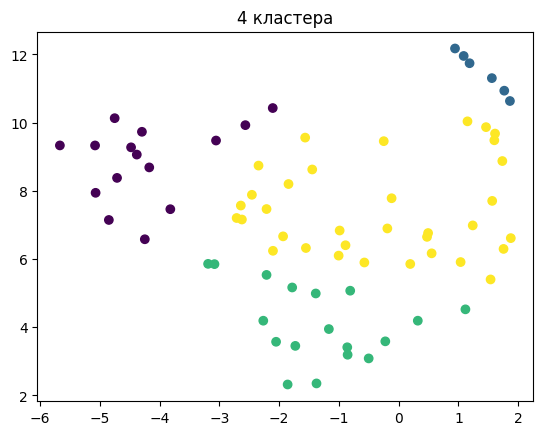

In [73]:
transformed_4 = model.fit_transform(q_population[dirty_col])

x_axis = transformed_4[:, 0]
y_axis = transformed_4[:, 1]

plt.scatter(x_axis, y_axis, c=q_population['Кластер_4'])
plt.title('4 кластера')
plt.show()


Посчитаем доверительный интервал в 95% для каждого параметра каждого кластера:

In [74]:
def confidence_intervals(dataset, col: str, clust_name: str, cluster: int):
    x = np.array(dataset[col].loc[dataset[clust_name] == cluster])

    n_iterations = 1000
    n_size = int(len(x))

    medians = list() 
    for _ in range(n_iterations): 
        s = resample(x, n_samples=n_size)
        m = np.median(s); 
        medians.append(m)

    alpha = 0.95
    p = ((1.0-alpha)/2.0) * 100
    lower =  np.percentile(medians, p) 
    p = (alpha+((1.0-alpha)/2.0)) * 100
    upper =  np.percentile(medians, p)
    
    return medians, [x for x in medians if x > lower and x < upper], max(medians), np.mean(x)

In [75]:
def draw_mp_plots(dataset, col: List[str], cluster_name: str):

    plt.figure(figsize = (20, 14))

    cluster = 0

    n_cluster, n_cols = len(set(dataset[cluster_name])), len(col)

    modas, means = {}, {}
    for i in range(n_cols*n_cluster):
        data, interval, moda, mean = confidence_intervals(dataset, col[i%n_cols], cluster_name, cluster)
        plt.subplot(n_cluster, n_cols, i+1)
        plt.hist(data)
        plt.hist(interval)
        plt.title(f'{col[i%n_cols][:20]} для {cluster} кластера', fontsize=8)

        if col[i%n_cols] not in modas:
            modas[col[i%n_cols]] = []
        modas[col[i%n_cols]].append((moda, cluster))

        if col[i%n_cols] not in means:
            means[col[i%n_cols]] = []
        means[col[i%n_cols]].append((mean, cluster))

        if i%n_cols == n_cols-1:
            cluster += 1

    plt.show()

    return modas, means

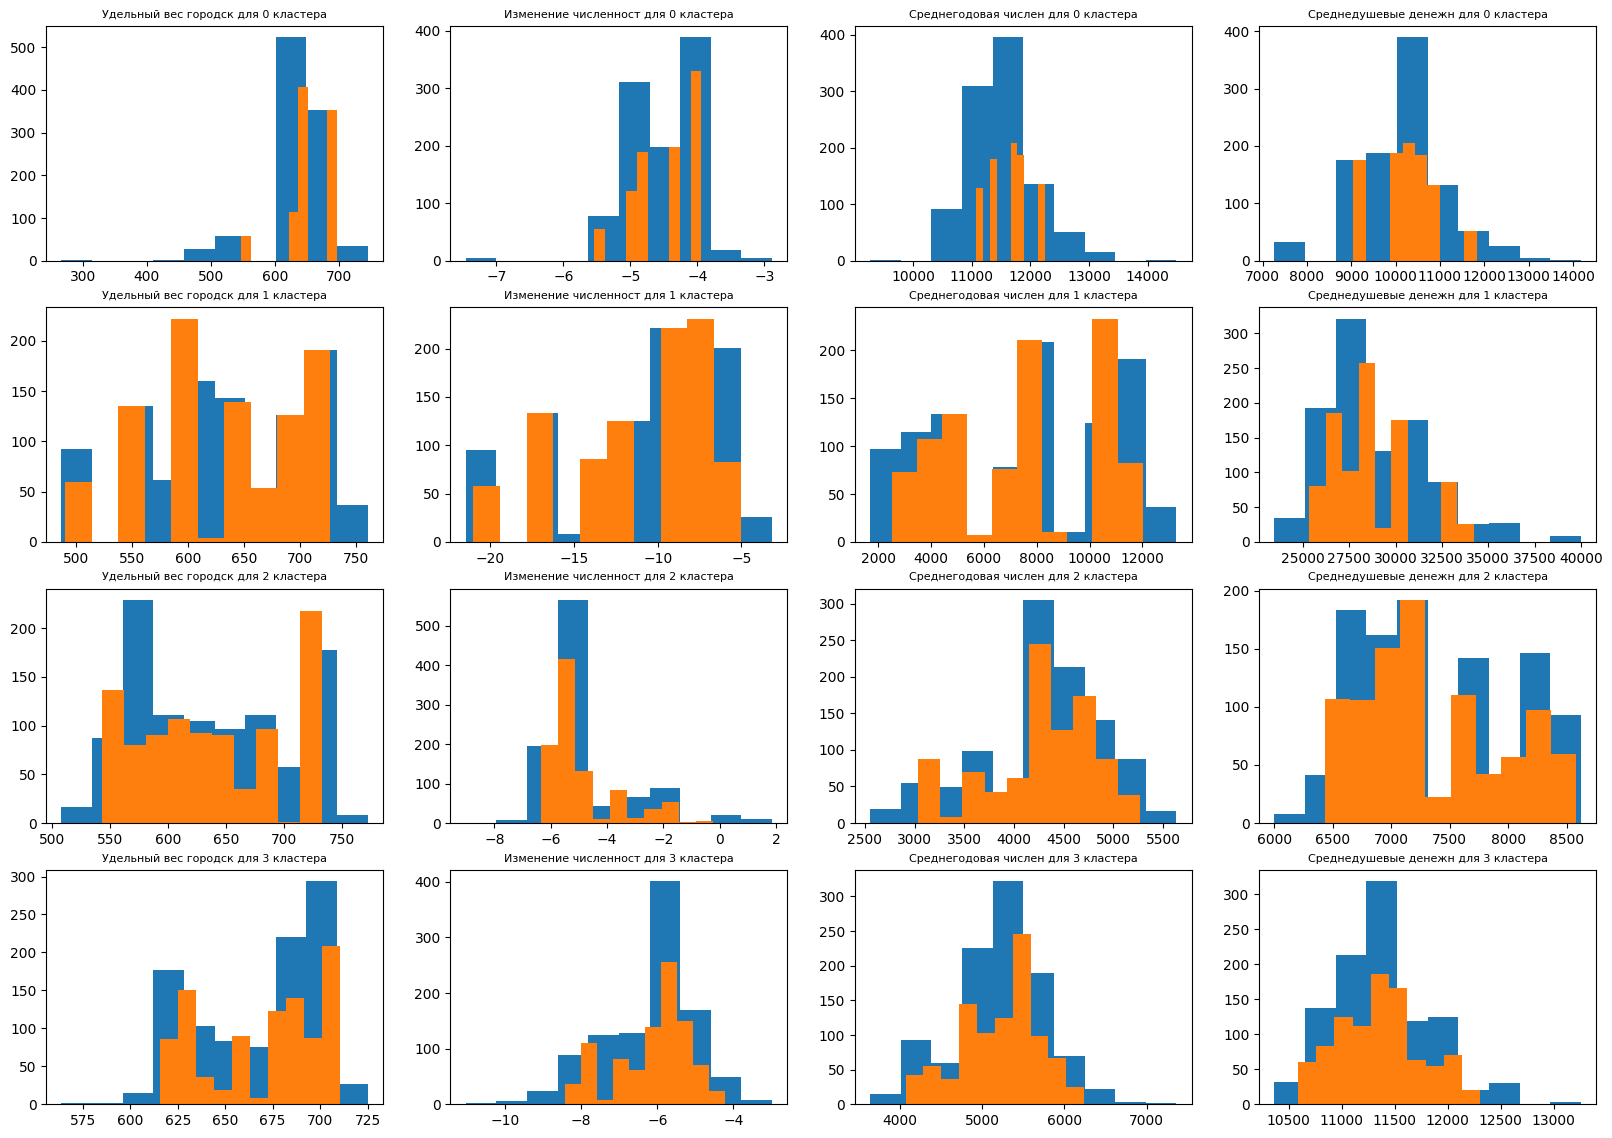

In [76]:
modas_4, means_4 = draw_mp_plots(q_population, dirty_col, 'Кластер_4')

Графики моды синим и среднего красным для каждого кластера по каждому параметру:

In [77]:
def moda_means(modas, means, sub1 = 2, sub2 = 2):
    plt.figure(figsize = (20, 14))
    for iter, col_values in enumerate(modas.items()):
        plt.subplot(sub1, sub2, iter+1)
        plt.bar([x[1]+1 for x in col_values[1]], [x[0] for x in col_values[1]])
        plt.title(col_values[0], fontsize=8) 
    for iter, col_values in enumerate(means.items()):
        plt.subplot(sub1, sub2, iter+1)
        plt.bar([x[1]+1 for x in col_values[1]], [x[0] for x in col_values[1]],  color='r', alpha=0.7)

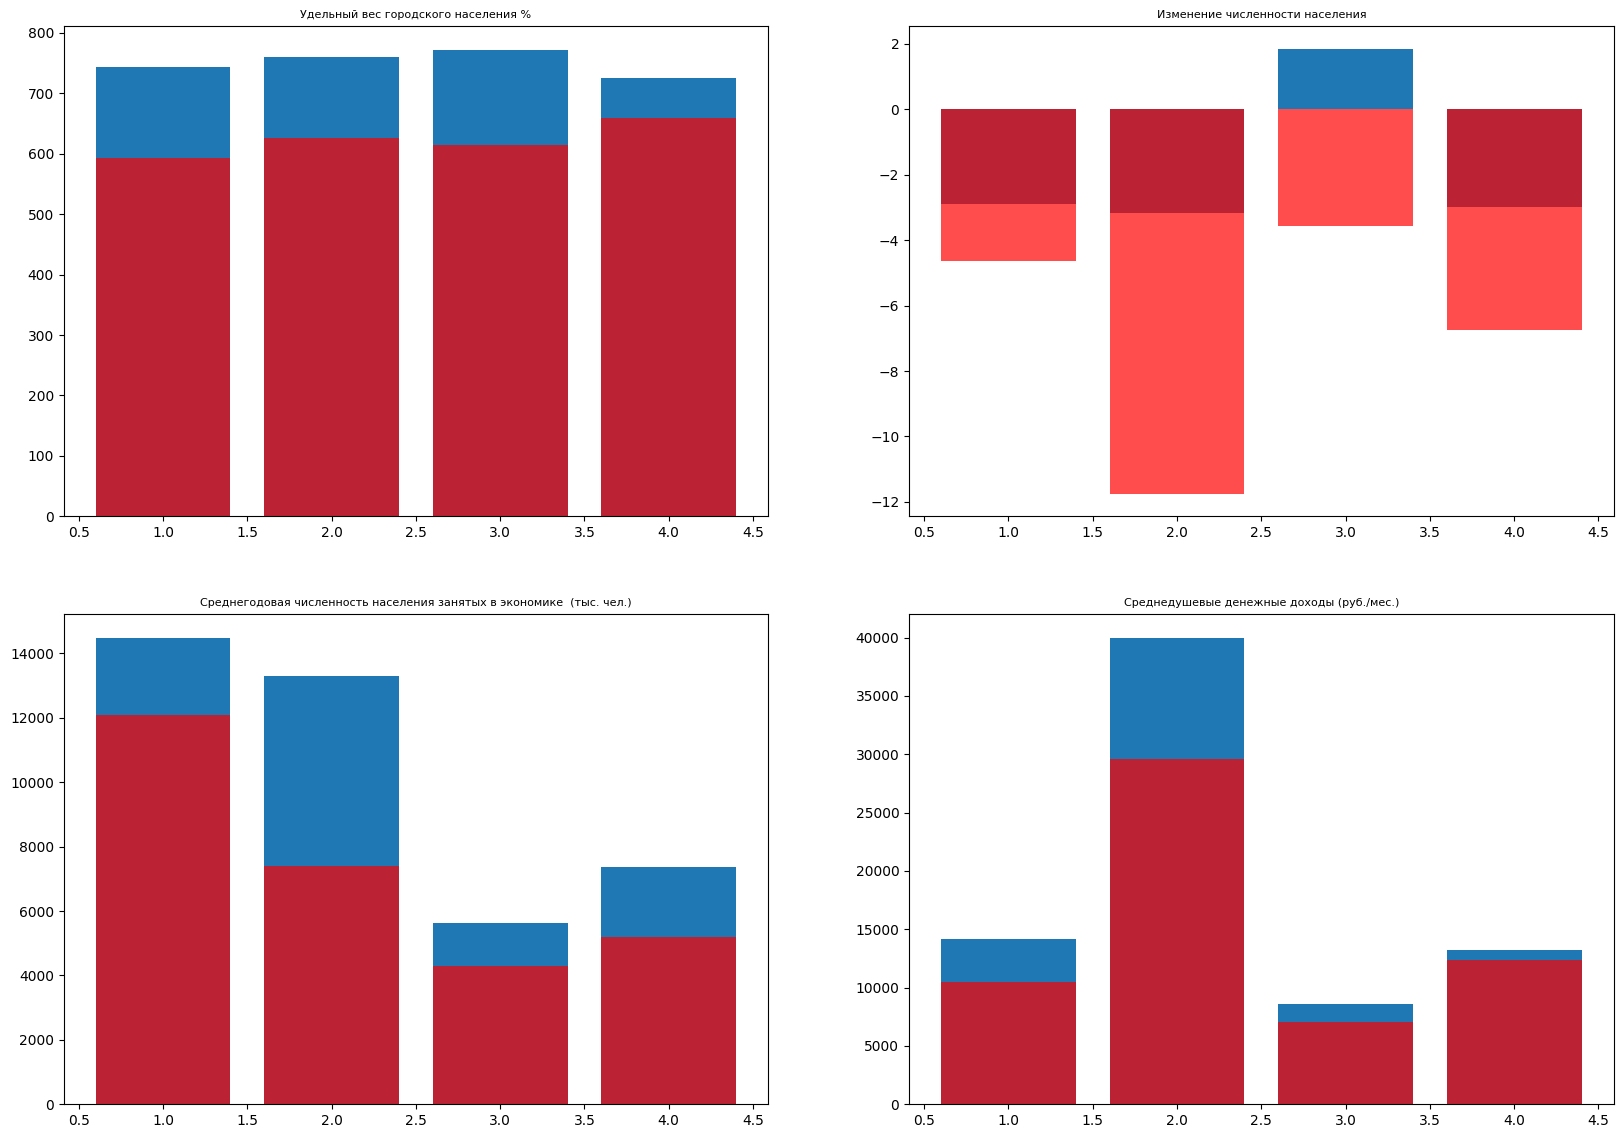

In [78]:
moda_means(modas_4, means_4)

Проделаем аналогично для 5 кластеров:

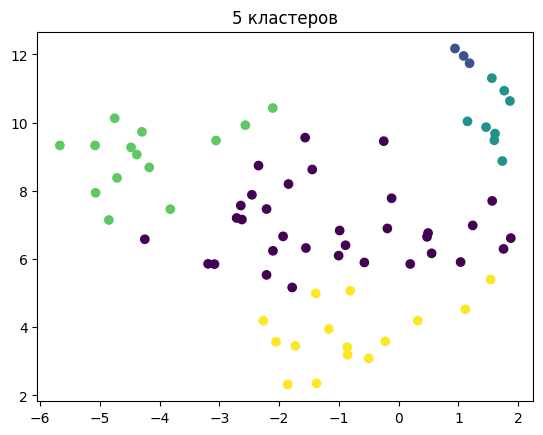

In [79]:
transformed = model.fit_transform(q_population[dirty_col])

x_axis = transformed[:, 0]
y_axis = transformed[:, 1]

plt.scatter(x_axis, y_axis,  c=q_population['Кластер_5'])
plt.title('5 кластеров')
plt.show()

Доверительные интервалы для пяти кластеров:

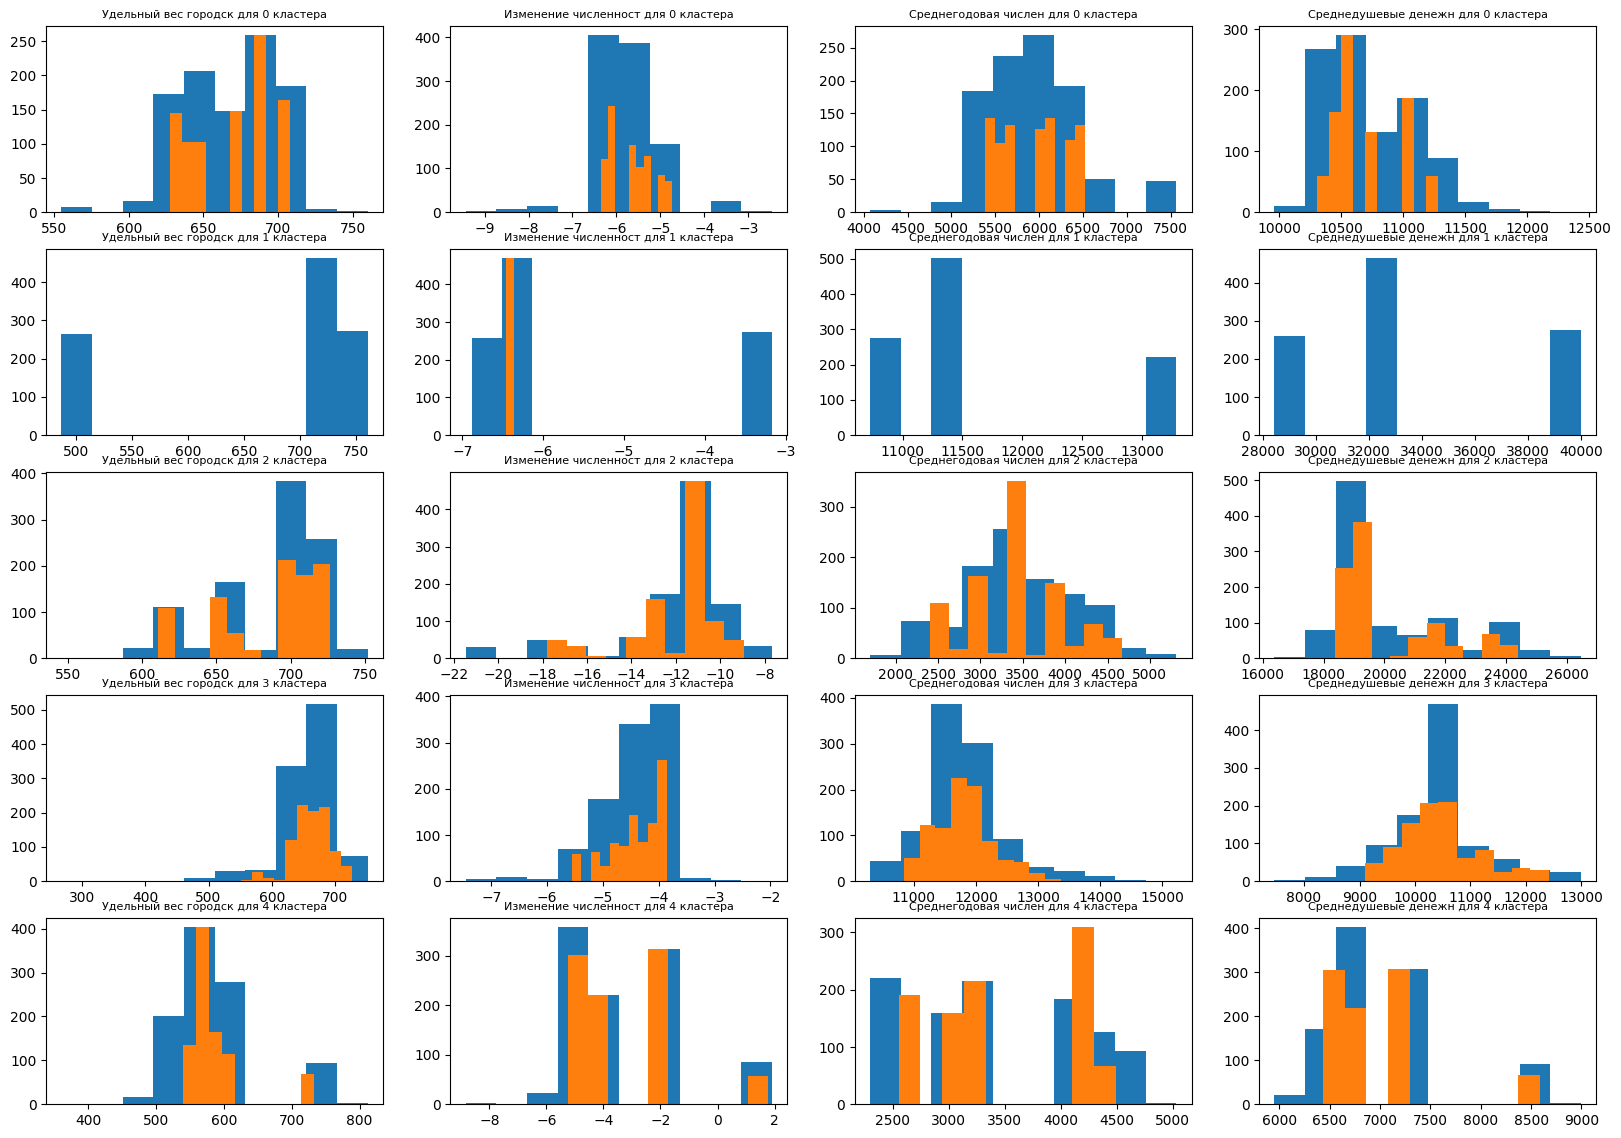

In [80]:
modas_5, means_5 = draw_mp_plots(q_population, dirty_col, 'Кластер_5')

Средние и максимальные значения для пяти кластеров:

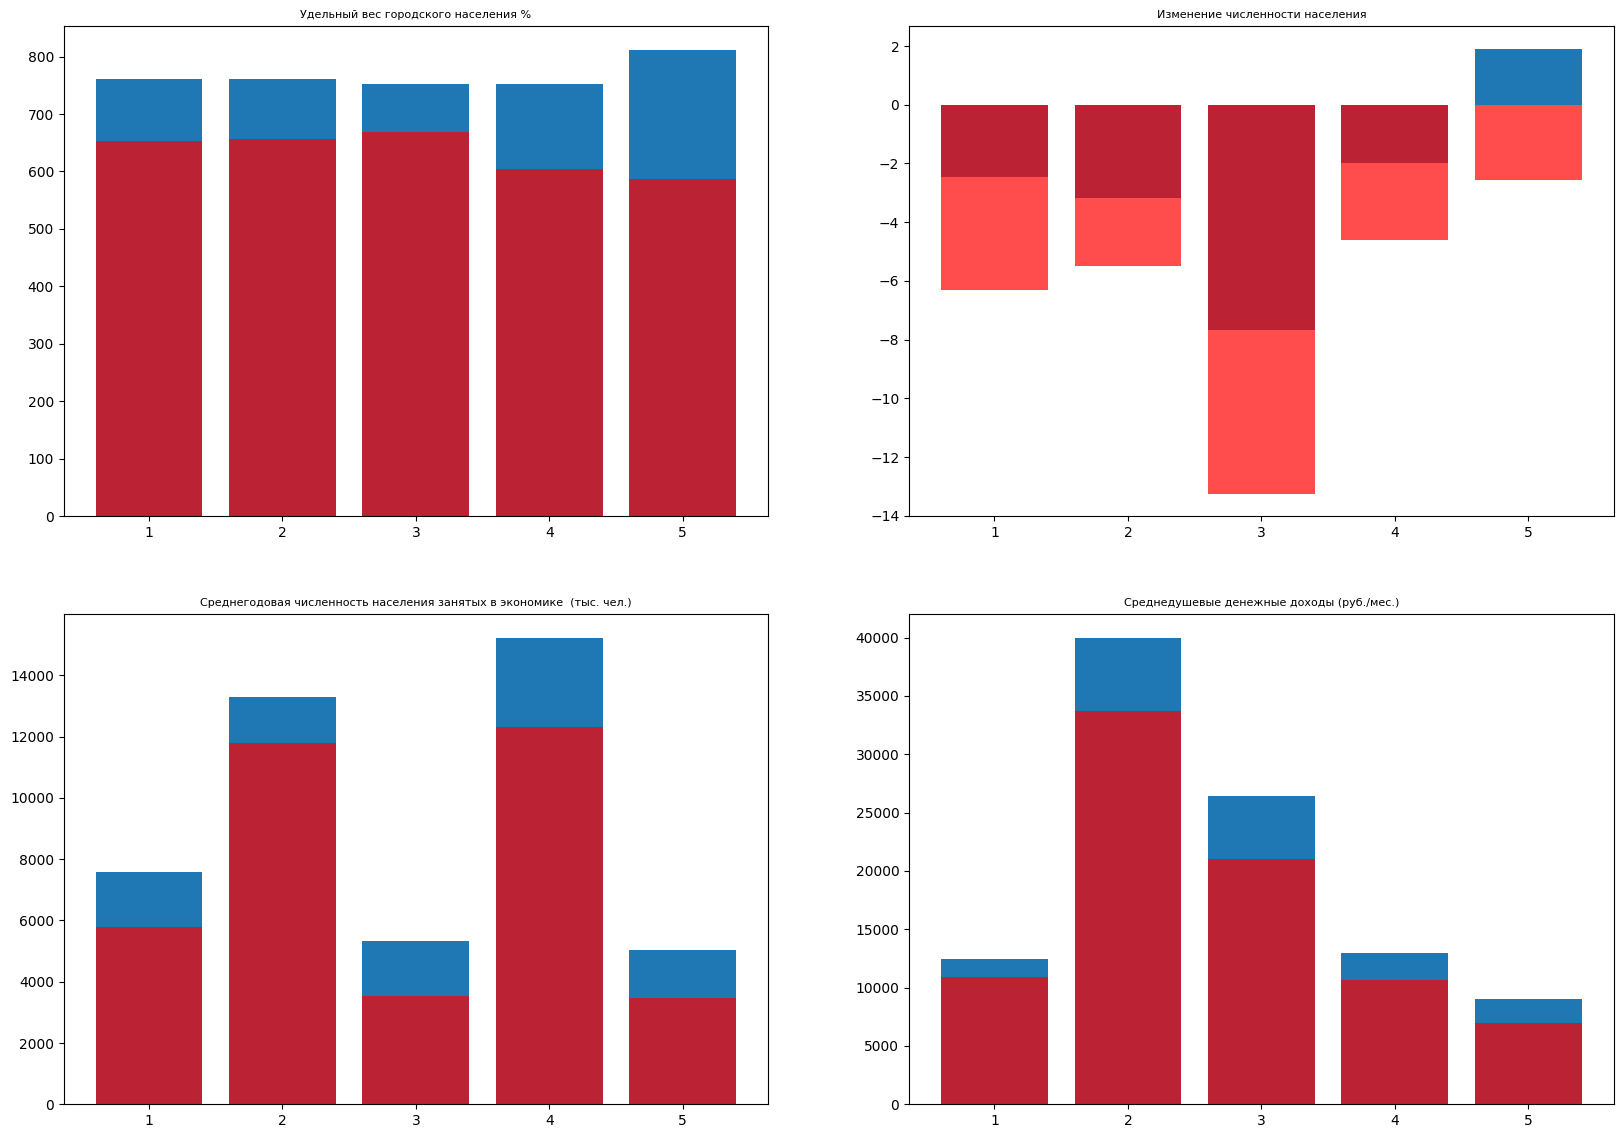

In [81]:
moda_means(modas_5, means_5)

**Вывод**:

Лучше справилась модель с 5 кластерами, она выделила: 
* **пятый кластер**, в котором тенденция к положительному росту населения и более низкие доходы, по сравнению с другими регионами (интересно, есть ли тут корреляция...);
* **второй кластер**, где в среднем самый высокий доход по регионам и ходит в топ два по количеству человек, занятых в экономике;
* **четвертый кластер**, являющимся вторым по доходам регионом и сохраняющий самую отрицательную тенденцию в убыли населения;
* **первый кластер** - не имеет характерных отличительных черт по сравению с другими регионами, однако представляет собой усредненные значения в обзоре всех кластеров;
* **третий кластер** - имеет самую высокую среднегодовую численность населения, занятых в экономике, однако доходы не превышают средние доходы во втором кластере, а втрое меньше их.

Интерпертировать выводы стоит с оглаской, так как нет возможности провалидировать качество кластеризации и обработки данных.

**Вопросы для самоконтроля**:
1. Что такое кластер?
2. Чем кластеризация отличается от классификации?
3. Что такое мощность кластера (поддержка), значимость полей? Как эти показатели могут быть использованы в интерпретации результатов кластеризации?
4. Какие способы визуализации доступны для представления
результатов кластеризации?
5. В чем отличие представления многомерной диаграммы в виде поверхности или топографической карты?

1. Кластер — это группа объектов, схожих по определённым признакам или характеристикам между собой, но отличающихся от объектов других групп (кластеров). Методы кластеризации применяются для определения этих групп (или сегментов) на основании анализа исходных данных без использования заранее заданных категорий.

2. Кластеризация отличается от классификации основным способом использования данных:
   - Кластеризация — это метод обучения без учителя, который используется для группировки набора объектов в таким образом, чтобы объекты в каждой группе (кластере) были более похожи друг на друга по сравнению с объектами в других кластерах.
   - Классификация — это метод обучения с учителем, при котором модель стремится отнести объект к одной из предварительно определенных категорий (классов) на основе подготовленных данных, содержащих примеры с указанием их категорий.

3. Мощность кластера (поддержка) обозначает количество элементов или объектов в кластере. Значимость полей устанавливает, насколько важны отдельные переменные или атрибуты для определения структуры кластера. Использование этих показателей в анализе помогает:
   - Определить насколько крупным или значимым является кластер.
   - Понять, какие признаки сыграли ключевую роль в формировании кластеров, что может помочь в интерпретации и понимании поведения данных.

4. Для визуализации результатов кластеризации используются различные методы:
   - Диаграммы рассеяния (Scatter plots), позволяющие визуализировать распределение кластеров в двухмерном или трехмерном пространстве.
   - Дендрограммы, отображающие иерархическую структуру кластеров.
   - Тепловые карты (Heatmaps), показывающие интенсивность или степень схожести объектов по различным параметрам.
   - Визуализация с помощью t-SNE или PCA, предоставляющая возможности для изучения многомерного пространства данных на двумерных или трехмерных плоскостях.

5. Отличие многомерной диаграммы в виде поверхности от топографической карты заключается в следующем:
   - Поверхностная диаграмма представляет данные в форме трехмерной поверхности, где оси представляют переменные, и высота поверхности в каждой точке отражает значение.
   - Топографическая карта отображает данные, используя цветовые схемы для указания различий в значениях аналогично географическим картам высот, что позволяет лучше воспринимать плотность или распределение значений в двухмерной плоскости. Это может быть полезно для визуализации плотности кластеров или ключевых областей в данных.

## Практика 3. САМООРГАНИЗУЮЩИЕСЯ КАРТЫ КОХОНЕНА 

### Кластеризация банков

Читаем данные:

In [82]:
banks = pd.read_csv("banks.csv", encoding='windows-1251', sep='\t')
banks.head()

,Номер,Банк,Рег. Номер,Реутеры,Филиалы,Город,Количество рабочих,Сумма активов,Собственные активы,Банковские активы,...,Привил. ресурсы,"Ссуда, руб.","Ссуда, долл.",Средства в Банке,Межфилиальные средства,Бюджет,Прибыль,Карты,Гос. облигации,Средства ДУ
0,2,Внешторгбанк,1000.0,-,32,Москва,3297,101660298,23236327,84343558,...,18053156,6588171,14842031,30863714,5919300,0,245820,348793,749356,0
1,3,Газпромбанк,354.0,GZPM,27,Москва,2559,79012789,9255041,74409960,...,10154247,8470823,31267375,18833125,4313630,0,355197,455520,123111,8316761
2,4,"ООО ""Международный Промышленный банк""",2056.0,TIBP,4,Москва,459,77888642,26409116,58647197,...,25093336,34043343,8405719,6712070,19195367,23917,306196,3255,38504,1662557
3,5,Международный Московский Банк,1.0,IMBX,1,Москва,621,63910966,1176462,62436148,...,3600147,462037,7797623,38973392,830525,0,0,178071,2033200,720
4,6,"ОАО ""АЛЬФА-БАНК""",1326.0,ALFM,17,Москва,2323,57510886,12446938,52348562,...,11527973,4987776,6077191,28996950,5104405,1594071,1218928,1012419,187085,0


In [83]:
banks.describe()

,Номер,Рег. Номер,Филиалы,Количество рабочих,Сумма активов,Собственные активы,Банковские активы,Депозиты физ. лиц,Депозиты Юр. лиц,Привил. ресурсы,"Ссуда, руб.","Ссуда, долл.",Средства в Банке,Межфилиальные средства,Бюджет,Прибыль,Карты,Гос. облигации,Средства ДУ
count,99.000000,98.000000,99.000000,99.000000,9.900000e+01,9.900000e+01,9.900000e+01,9.900000e+01,9.900000e+01,9.900000e+01,9.900000e+01,9.900000e+01,9.900000e+01,9.900000e+01,9.900000e+01,9.900000e+01,9.900000e+01,9.900000e+01,9.900000e+01
mean,51.000000,1817.408163,20.101010,732.626263,1.028106e+07,1.518004e+06,8.166384e+06,4.655222e+05,3.290871e+06,1.443386e+06,1.694367e+06,1.566500e+06,2.213331e+06,1.536201e+06,5.307094e+04,8.146619e+04,7.113434e+04,2.728352e+05,1.737630e+05
std,28.722813,995.484007,113.580637,863.623543,1.759679e+07,3.798087e+06,1.502554e+07,7.272206e+05,7.235302e+06,3.569150e+06,3.780585e+06,3.867671e+06,6.021049e+06,4.125647e+06,2.421273e+05,1.677934e+05,1.536984e+05,5.840783e+05,1.049936e+06
min,2.000000,1.000000,0.000000,0.000000,1.324791e+06,0.000000e+00,1.814560e+05,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,-1.409180e+05,0.000000e+00,0.000000e+00,0.000000e+00
25%,26.500000,913.500000,1.000000,191.000000,2.097878e+06,2.261490e+05,1.614724e+06,7.574600e+04,1.757235e+05,5.707450e+04,4.064630e+05,9.162750e+04,2.235120e+05,0.000000e+00,0.000000e+00,6.427000e+03,1.410000e+03,2.837000e+03,0.000000e+00
50%,51.000000,1982.500000,4.000000,320.000000,3.170956e+06,4.636600e+05,2.598064e+06,1.852990e+05,7.925660e+05,2.858150e+05,6.768550e+05,2.557250e+05,4.174880e+05,1.628680e+05,0.000000e+00,2.245900e+04,1.261000e+04,4.550500e+04,0.000000e+00
75%,75.500000,2588.500000,10.500000,935.000000,9.661892e+06,1.127823e+06,6.779936e+06,5.184865e+05,2.787508e+06,1.010068e+06,1.376008e+06,1.158152e+06,1.536078e+06,1.103186e+06,0.000000e+00,7.634550e+04,6.209800e+04,2.001850e+05,0.000000e+00
max,100.000000,3292.000000,1132.000000,3579.000000,1.016603e+08,2.640912e+07,8.434356e+07,4.052929e+06,4.283159e+07,2.509334e+07,3.404334e+07,3.126738e+07,3.897339e+07,3.190323e+07,1.594071e+06,1.218928e+06,1.012419e+06,3.377772e+06,8.316761e+06


In [84]:
banks.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 99 entries, 0 to 98
Data columns (total 22 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   Номер                   99 non-null     int64  
 1   Банк                    99 non-null     object 
 2   Рег. Номер              98 non-null     float64
 3   Реутеры                 99 non-null     object 
 4   Филиалы                 99 non-null     int64  
 5   Город                   99 non-null     object 
 6   Количество рабочих      99 non-null     int64  
 7   Сумма активов           99 non-null     int64  
 8   Собственные активы      99 non-null     int64  
 9   Банковские активы       99 non-null     int64  
 10  Депозиты физ. лиц       99 non-null     int64  
 11  Депозиты Юр. лиц        99 non-null     int64  
 12  Привил. ресурсы         99 non-null     int64  
 13  Ссуда, руб.             99 non-null     int64  
 14  Ссуда, долл.            99 non-null     int6

Отберем параметры:

In [85]:
banks.columns

Index(['Номер', 'Банк', 'Рег. Номер', 'Реутеры', 'Филиалы', 'Город',
       'Количество рабочих', 'Сумма активов', 'Собственные активы',
       'Банковские активы', 'Депозиты физ. лиц', 'Депозиты Юр. лиц',
       'Привил. ресурсы', 'Ссуда, руб.', 'Ссуда, долл.', 'Средства в Банке',
       'Межфилиальные средства', 'Бюджет', 'Прибыль', 'Карты',
       'Гос. облигации', 'Средства ДУ'],
      dtype='object')

In [86]:
bank_cols = ['Филиалы', 'Сумма активов', 'Собственные активы', 'Банковские активы', 'Средства в Банке']

Разделим данные:

In [87]:
bank_x = banks[bank_cols]
bank_y = banks['Прибыль']

In [88]:
data = bank_x.values
targets = bank_y.values 

Отобразим начальные данные с помощью цветовой карты:

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


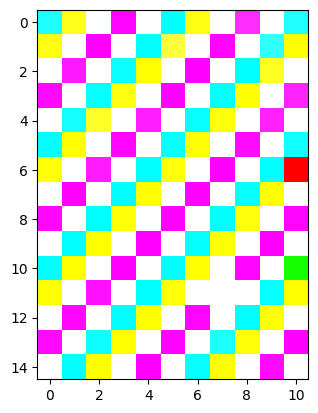

In [89]:
plt.imshow(data.reshape(15, 11, 3))
plt.show()

Представлено 5 различных цветов, 4 из которых встречаются почти равномерно часто.

Отмасштабируем данные для обучения:

In [90]:
from sklearn.preprocessing import StandardScaler

In [91]:
scaler = StandardScaler()
scaler.fit(data)

StandardScaler()

In [92]:
scaler.mean_

array([2.01010101e+01, 1.02810565e+07, 1.51800433e+06, 8.16638408e+06,
       2.21333062e+06])

Реализуем итерационно алгоритм самоорганизующихся карт Кохонена с евклидовой метрикой растояния.

In [93]:
def som(data, k: int, alpha: float, n_iter: int):
    X = data

    n = len(X)
    d = len(X[0])
    addZeros = np.zeros((n, 1))
    X = np.append(X, addZeros, axis=1)

    weight = np.random.rand(d, k)
    start_weight = weight.copy()
    for _ in range(n_iter):
        for i in range(n):
            distMin = 99999999
            for j in range(k):
                dist = np.square(distance.euclidean(weight[:,j], X[i,0:d]))
                if distMin > dist:
                    distMin = dist
                    jMin = j
            weight[:,jMin] = weight[:,jMin]*(1-alpha) + alpha*X[i,0:d]
        alpha = 0.5*alpha

    for i in range(n):
        cluster, distMin = 0, 999999999
        for j in range(k):
            dist = np.square(distance.euclidean(weight[:,j], X[i,0:d]))
            if distMin > dist:
                distMin = dist
                cluster = j
        X[i,d] = cluster
    
    
    return start_weight, weight, X

Количество кластеров выберем 4, скорость обучения 0.6, количество итераций 10000:

In [94]:
k = 4
alpha = 0.6
n_iter = 10000


tr_data = scaler.transform(data)

Обучим модель:

In [95]:
start, weights, result = som(tr_data, k, alpha, n_iter)

Отобразим результаты с помощью понижения пространства:

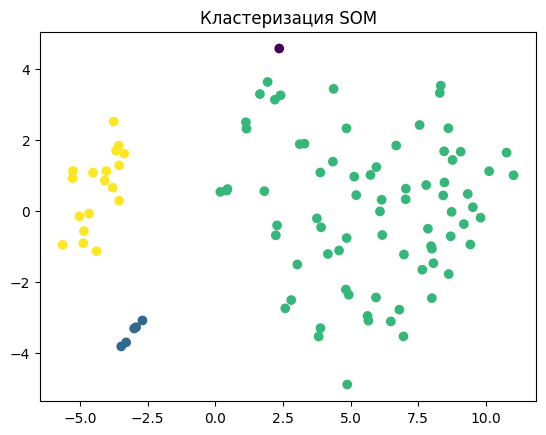

In [96]:
transformed_bank = model.fit_transform(result)

x_axis = transformed_bank[:, 0]
y_axis = transformed_bank[:, 1]

plt.scatter(x_axis, y_axis, c=result[:, -1])
plt.title('Кластеризация SOM')
plt.show()


Посомтрим данные по каждому кластеру:

In [97]:
banks['Кластер'] = result[:, -1]

In [98]:
for k, cnt in [(k, banks.loc[banks['Кластер'] == k]['Кластер'].count()) for k in range(4)]:
    print(f'Кластер: {k} количество: {cnt}')

Кластер: 0 количество: 1
Кластер: 1 количество: 5
Кластер: 2 количество: 75
Кластер: 3 количество: 18


In [99]:
banks.loc[banks['Кластер'] == 0].head(3)

,Номер,Банк,Рег. Номер,Реутеры,Филиалы,Город,Количество рабочих,Сумма активов,Собственные активы,Банковские активы,...,"Ссуда, руб.","Ссуда, долл.",Средства в Банке,Межфилиальные средства,Бюджет,Прибыль,Карты,Гос. облигации,Средства ДУ,Кластер
77,79,"ОАО ""СОЦИНВЕСТБАНК""",11.0,-,1132,Уфа,1177,1790708,222197,1654724,...,532518,1096,175156,105444,0,39848,1529,109693,0,0.0


In [100]:
banks.loc[banks['Кластер'] == 1].head(3)

,Номер,Банк,Рег. Номер,Реутеры,Филиалы,Город,Количество рабочих,Сумма активов,Собственные активы,Банковские активы,...,"Ссуда, руб.","Ссуда, долл.",Средства в Банке,Межфилиальные средства,Бюджет,Прибыль,Карты,Гос. облигации,Средства ДУ,Кластер
0,2,Внешторгбанк,1000.0,-,32,Москва,3297,101660298,23236327,84343558,...,6588171,14842031,30863714,5919300,0,245820,348793,749356,0,1.0
1,3,Газпромбанк,354.0,GZPM,27,Москва,2559,79012789,9255041,74409960,...,8470823,31267375,18833125,4313630,0,355197,455520,123111,8316761,1.0
2,4,"ООО ""Международный Промышленный банк""",2056.0,TIBP,4,Москва,459,77888642,26409116,58647197,...,34043343,8405719,6712070,19195367,23917,306196,3255,38504,1662557,1.0


In [101]:
banks.loc[banks['Кластер'] == 2].head(3)

,Номер,Банк,Рег. Номер,Реутеры,Филиалы,Город,Количество рабочих,Сумма активов,Собственные активы,Банковские активы,...,"Ссуда, руб.","Ссуда, долл.",Средства в Банке,Межфилиальные средства,Бюджет,Прибыль,Карты,Гос. облигации,Средства ДУ,Кластер
21,23,"ОАО ""Ханты-Мансийский банк """,1971.0,-,6,Ханты-Мансийск,473,12722589,323652,2987333,...,574549,60600,705074,475546,55,30679,51722,64584,0,2.0
22,24,"ОАО ""Банк ""Петровский """,729.0,PETR,18,Санкт-Петербург,3395,12589085,439907,5943321,...,2255752,785076,100843,6624531,0,12461,81654,710009,0,2.0
25,27,НОМОС-БАНК,2209.0,NMOS,1,Москва,260,8916553,1416318,8799375,...,3275069,1126402,1798646,99319,0,16548,27282,396064,137,2.0


In [102]:
banks.loc[banks['Кластер'] == 3].head(3)

,Номер,Банк,Рег. Номер,Реутеры,Филиалы,Город,Количество рабочих,Сумма активов,Собственные активы,Банковские активы,...,"Ссуда, руб.","Ссуда, долл.",Средства в Банке,Межфилиальные средства,Бюджет,Прибыль,Карты,Гос. облигации,Средства ДУ,Кластер
5,7,"ОАО ""ПСБ""",439.0,ICSP,44,Санкт-Петербург,3579,49406525,1275859,17091603,...,5187620,3416332,2626908,31903232,0,271635,153087,1696127,10509,3.0
6,8,Банк Москвы,2748.0,-,34,Москва,2810,31352124,3335734,30287158,...,8826718,4860894,3781859,945517,0,53771,221612,0,0,3.0
7,9,"АКБ ""РОСБАНК"" (ОАО)",2272.0,-,13,Москва,989,28105202,4691449,25807591,...,6691829,5882163,8848426,1479585,607332,257710,134021,774727,0,3.0


Отобразим доверительный интервал для каждого кластера:

In [103]:
bank_cols.append('Прибыль')

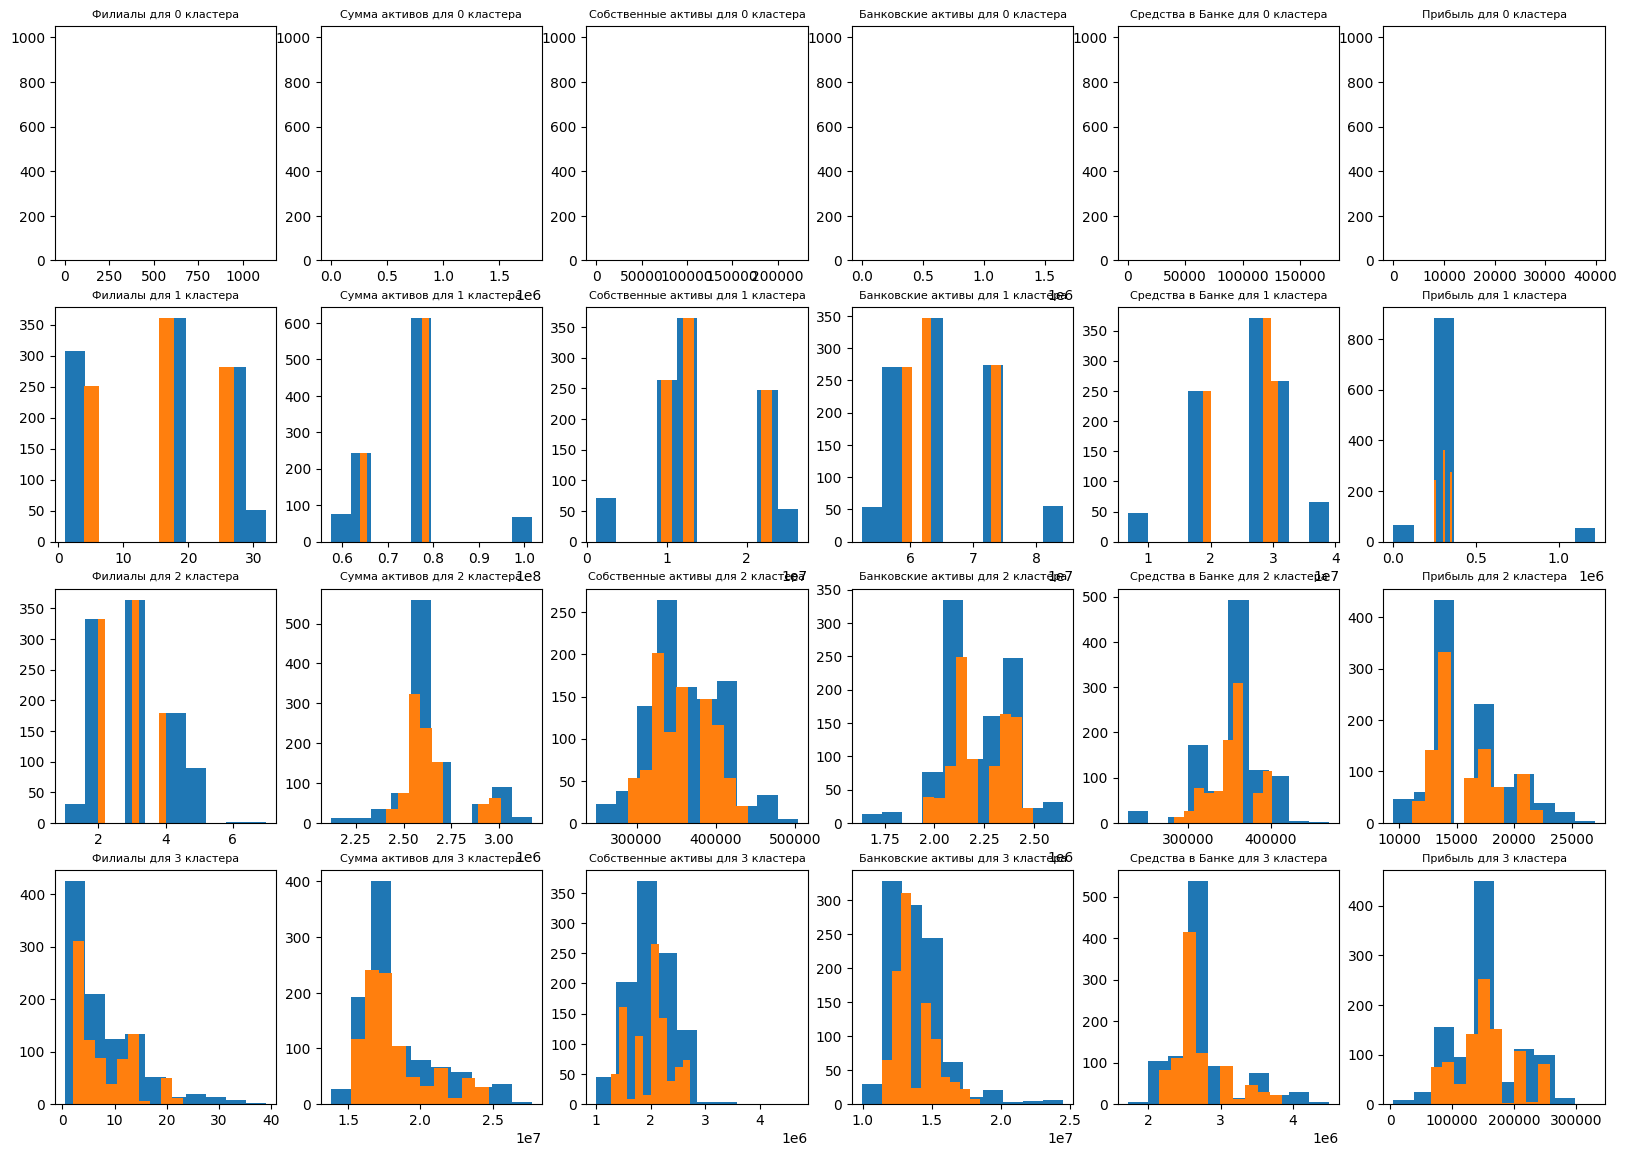

In [104]:
modas_b, means_b = draw_mp_plots(banks, bank_cols, 'Кластер')

Отобразим моду и среднее для каждого параметра кластера:

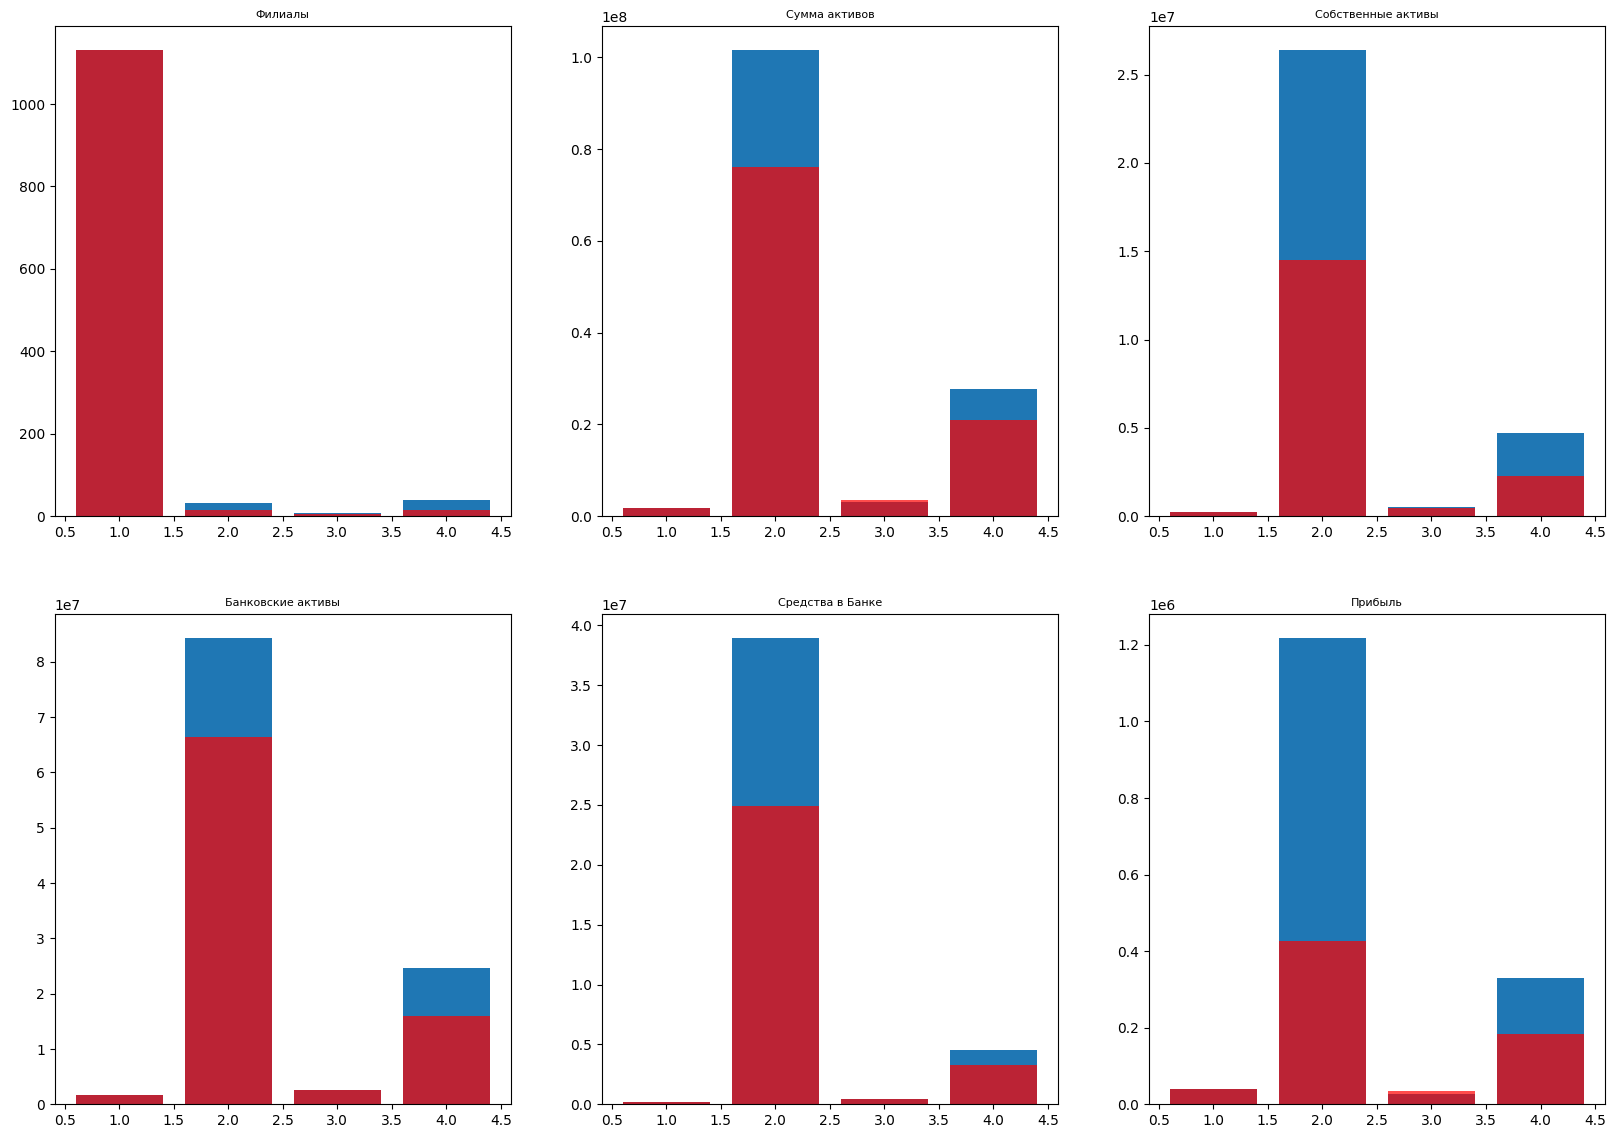

In [105]:
moda_means(modas_b, means_b, sub1=2, sub2=3)

### Вопросы для самоконтроля

1. Что такое карта Кохонена?
2. Для решения каких задач используются самоорганизующиеся карты Кохонена?
3. В чем отличие самоорганизующихся карт Кохонена от других средств отображения кластеризации?
4. Зачем производится раскраска ячеек?
5. Как определить число кластеров в обработчике Карта Кохонена?
6. Что такое обучение без учителя?
7. Что отображает карта Матрица расстояний?

1. Карта Кохонена или самоорганизующаяся карта (SOM, Self-Organizing Map), - это тип искусственной нейронной сети, который выполняет кластеризацию данных, одновременно производя снижение размерности данных, часто используемый для визуализации сложных данных.

2. Самоорганизующиеся карты Кохонена используются для:
   - Визуализации высокоразмерных данных.
   - Кластеризации больших наборов данных.
   - Обнаружения структурных схожестей в данных.
   - Упрощения и интерпретации данных.

3. Отличие самоорганизующихся карт Кохонена от других методов кластеризации в том, что они обеспечивают одновременное снижение размерности и визуализацию кластеров, сохраняя при этом топологические свойства исходных данных. В отличие от других визуальных методов кластеризации, таких как PCA или t-SNE, SOM формирует карту, где схожие объекты группируются в смежных областях карты, что делает структуру данных более понятной.

4. Раскраска ячеек на карте Кохонена проводится для визуального выделения различных кластеров или для показа различий в значениях конкретных переменных между нейронами. Цветовая кодировка помогает быстрее воспринимать информацию и анализировать различия между кластерами на карте.

5. Определить число кластеров на карте Кохонена можно разными методами, включая визуальный осмотр карты, анализ распределения расстояний между точками на карте и использование дополнительных статистических методов, таких как иерархическая кластеризация или метод k-средних, применяемый к весам нейронов самоорганизующейся карты.

6. Обучение без учителя — метод машинного обучения, при котором модель обучается на основе входных данных без предварительно заданных ответов или меток. Цель состоит в том, чтобы модель самостоятельно выявила закономерности и структуру в данных, что отличается от обучения с учителем, где обучение происходит на основе известных входных и выходных данных.

7. Карта "Матрица расстояний" отображает визуальное представление расстояний или близости между различными элементами датасета, позволяя пользователю оценить, как элементы сгруппированы или разделены друг от друга. Эта карта может использоваться для визуализации сходства или различий между объектами, часто используется для представления результатов иерархической кластеризации или других методов измерения расстояний.